In [1]:
from langgraph.graph import StateGraph, START, END
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated,TypedDict,Literal,Dict,List,Any,Optional
from bs4 import BeautifulSoup
from langgraph.checkpoint.sqlite import SqliteSaver
import requests # Added import
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage,BaseMessage
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent,tools_condition,ToolNode
from finnhub import Client
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.vectorstores import Chroma
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_core.documents import Document
import pandas as pd
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from pathlib import Path
import os
from langchain_core.tools import tool
import sys
import finnhub
import os
from langchain.tools import tool
from typing import Dict, Any,List,Optional,Literal
from pydantic import BaseModel,Field
import time 
import shutil
from langgraph_supervisor import create_supervisor,create_handoff_tool
from langgraph_swarm import create_swarm,create_handoff_tool
from datetime import datetime,timedelta
from sec_api import QueryApi
import requests
from sec_edgar_api import EdgarClient
import json
import pandas_ta as ta
import os
import asyncio
import aiohttp
import sqlite3
import logging
import regex as re
import requests
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
load_dotenv()



/Users/divyyadav/miniforge3/envs/newenv/lib/python3.10/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


True

In [2]:
def main_memory(database_name:str,reset:bool=True):
    data_dir=os.path.join('..','data')
    os.makedirs(data_dir,exist_ok=True)

    data_path=os.path.join(data_dir,database_name)
    if os.path.exists(data_path) and reset:
        os.remove(data_path)
    conn=sqlite3.connect(data_path,check_same_thread=False)
    memory=SqliteSaver(conn)
    return memory

In [3]:
def validate_api_kets():
    """Validates that all required API keys are present in environment variables."""
    required_keys = [
        "Alpha_Vantage_Stock_API",
        "FINNHUB_API_KEY",
        "SEC_API_KEY",
        "FPREP",
        "polygon_api",
        "TAVILY_API_KEY",
        "google"  
    ]
    missing_keys=[]

    for key in required_keys:
        if os.getenv(key) is None:
            missing_keys.append(key)
            print(f"The '{key}' environment variable is missing.")
            return missing_keys
    return True

In [4]:
class HeimdallState(TypedDict):
    ticker: str
    company_name: str
    mission_plan: Optional[str]
    financial_report: Optional[str]
    news_report: Optional[str]
    technical_report: Optional[str]
    research_report: Optional[str]
    economic_report: Optional[str]
    risk_report: Optional[str]
    valuation_report: Optional[str]
    dcf_analysis: Optional[str]
    comps_analysis: Optional[str]
    precedent_analysis: Optional[str]
    final_report: Optional[str]
    validation_report: Optional[str]
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
model=ChatGoogleGenerativeAI(api_key=os.getenv('google'),model='gemini-2.5-flash')

In [6]:

class Sentiment(BaseModel):
    sentiment: Literal['positive','negative','neutral'] = Field(..., description="you need to classify the sentiment of the message based on the analysis")
    reason: str = Field(..., description="you need to give the reason for the sentiment classification")
    positive_factors: str = Field(..., description="List positive factors affecting the sentiment")
    negative_factors: str = Field(..., description="List negative factors affecting the sentiment") 
    neutral_factors: str = Field(..., description="List neutral factors affecting the sentiment")


In [7]:
@tool(description="Gets comprehensive information about a company")
async def company_overview(ticker: str):
    """
    Retrieves detailed company information including financial metrics,
    business description, and key statistics from Alpha Vantage API.
    
    Args:
        ticker: Stock symbol of the company (e.g., 'AAPL', 'MSFT')
        
    Returns:
        Dict containing company overview data or error information
    """
    api = os.getenv('Alpha_Vantage_Stock_API')
    if not api:
        return {'error': 'API KEY IS MISSING'}
    
    try:
        url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={api}'
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                response.raise_for_status()
                data = await response.json()
                
        if "Note" in data or not data:
            return {"error": f"Could not fetch data for {ticker}. API limit may be reached or ticker is invalid."}
            
        return data
    except aiohttp.ClientError as e:
        return {'error': f"Request error: {str(e)}"}
    except Exception as e:
        return {'error': f"Unexpected error: {str(e)}"}


In [8]:
model2_wstr_output=model.with_structured_output(Sentiment)

In [9]:
model_with_structure=model.with_structured_output(Sentiment)

In [10]:
import os
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import create_react_agent

# Google Gemini model
model = ChatGoogleGenerativeAI(
    api_key=os.getenv("google"),
    model="gemini-2.5-flash"
)

# Tool to search the web
async def search_web(query: str):
    """Searches the web for the given query and returns the top results"""
    tavily = TavilySearchResults(max_results=20, api_key=os.getenv("TAVILY_API_KEY"))
    return await tavily.ainvoke(query)

@tool(description="searches the web for the given query and returns the top results")
async def search_web(query: str):
    """Searches the web for the given query and returns the top results"""
    tavily = TavilySearchResults(max_results=20, api_key=os.getenv("TAVILY_API_KEY"))
    return await tavily.ainvoke(query)

@tool(description='searches the web to get result')
def search_web2(query:str):
    """Searches the web for the given query and returns the top results"""
    a=DuckDuckGoSearchResults(max_results=20).invoke(query)
    return a


@tool("get_ticker_from_name")
async def get_ticker_from_name(company_name: str) -> str:
    """
    Asynchronously finds the ticker symbol for a company name using the Yahoo Finance search API.

    Args:
        company_name (str): The name of the company to search for.

    Returns:
        str: The ticker symbol if found, otherwise None.
    """
    import aiohttp

    url = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}
    headers = {'User-Agent': user_agent}

    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params, headers=headers) as res:
                res.raise_for_status()
                data = await res.json()

                if data and 'quotes' in data and data['quotes']:
                    first_quote = data['quotes'][0]
                    return first_quote['symbol']
                else:
                    return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


from typing import Optional
from pydantic import BaseModel, Field

# Improved schema for ticker
class TickerResponse(BaseModel):
    ticker: str = Field(..., description="The official stock ticker symbol for the company (e.g., MSFT for Microsoft)")

# Improved pre-processing agent with clearer prompt and structured output
pre_processing_agent = create_react_agent(
    model=model,
    response_format=TickerResponse,
    tools=[search_web, search_web2, get_ticker_from_name],
    name="pre_processing_agent",
    prompt="""
You are a specialized assistant. Your sole task is to extract the official stock ticker symbol for a given company name.

Instructions:
1. Use the `search_web`, `search_web2`, and `get_ticker_from_name` tools to search for the company's official ticker symbol.
2. Carefully review the search results and extract ONLY the correct ticker symbol (e.g., MSFT for Microsoft, AAPL for Apple, HDFCBANK.NS for HDFC Bank).
3. Return your answer strictly in this JSON format: {"ticker": "<TICKER_SYMBOL>"}
4. If you cannot find a valid ticker symbol, return {"ticker": "NOT_FOUND"}.

Important:
- Only return the ticker symbol in the specified JSON format.
- Do not include any additional information, explanation, or commentary.
"""
)


In [11]:

# IMPORTANT: The SEC API requires you to set a User-Agent.
# Replace 'Your Name' and 'your.email@example.com' with your actual info.
os.environ['EDGAR_USER_AGENT'] = 'Divy yadavdipu296@gmail.com'

import aiohttp
@tool(description='gets the latest 10k fillings')
async def get_latest_10k_filing(ticker: str) -> str:
    """
    Asynchronously fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.

    Args:
        ticker: The company's stock ticker (e.g., "TSLA").

    Returns:
        The plain text content of the 10-K filing's primary document.
        Returns an error message if the filing cannot be fetched.
    """
    print(f"---  SEC TOOL: Fetching latest 10-K for {ticker} ---")
    try:
        # Initialize QueryApi with your SEC API key
        query_api = QueryApi(api_key=os.getenv('SEC_API_KEY')) # Assumes SEC_API_KEY in .env

        # Query for the latest 10-K filing for the ticker
        query = {
            "query": {"query_string": {"query": f'ticker:{ticker} AND formType:"10-K"'}},
            "from": 0,
            "size": 1,
            "sort": [{"filedAt": {"order": "desc"}}],
        }
        response = query_api.get_filings(query=query)
        
        if not response or not response.get("filings"):
            return f"Error: No 10-K filings found for ticker {ticker}."

        # Get the URL of the primary document from the latest filing
        filing_url = response["filings"][0].get("linkToHtml")
        
        if not filing_url:
            return f"Error: Could not find a filing URL for {ticker}."

        # Fetch the content of the filing URL asynchronously using aiohttp
        async with aiohttp.ClientSession() as session:
            async with session.get(filing_url, headers={'User-Agent': os.getenv('EDGAR_USER_AGENT')}) as resp:
                filing_html = await resp.text()

        # Use BeautifulSoup to parse the HTML and extract all text
        soup = BeautifulSoup(filing_html, 'html.parser')
        plain_text = soup.get_text(separator='\n', strip=True)

        print(f"--- SEC TOOL: Successfully fetched and parsed 10-K for {ticker}. ---")
        return plain_text

    except Exception as e:
        return f"An error occurred while fetching the SEC data: {e}"



@tool(description="Searches the web for the the ticker and gives the result sentiment with analysis")
async def analyze_news_sentiment(ticker: str, days_back: int = 30) -> Dict[str, Any]:
    """
    Analyzes recent news sentiment for a given company ticker over a specified period.

    Args:
        ticker: The company's stock ticker (e.g., "TSLA").
        days_back: Number of days to look back for news articles (default: 30).

    Returns:
        A dictionary containing news sentiment analysis.
    """
    try:
        # Build query
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days_back)
        search_query = (
            f"{ticker} company news from {start_date.strftime('%Y-%m-%d')} "
            f"to {end_date.strftime('%Y-%m-%d')} about its performance and changes"
        )

        # ✅ Use async invocation properly
        news_result = await search_web(search_query)

        if not news_result:
            return {"error": f"No articles found for {ticker} in the given period."}

        # Collect top 10 articles
        news_text = ""
        for i, result in enumerate(news_result[:10], 1):
            news_text += f"Article {i}: {result.get('title', 'No title')}\n"
            news_text += f"Content: {result.get('content', 'No content')[:200]}...\n\n"

    except Exception as e:
        return {"error": f"Error fetching news articles: {e}"}

    # ✅ Sentiment analysis (always use ainvoke because these are async models)
    sentiment_result = await model_with_structure.ainvoke(news_text)

    # Generate final reasoning summary
    prompt = (
        f"Based on the following sentiment analysis: {sentiment_result}, "
        f"provide a detailed summary of the news sentiment with supporting reasons from the news text."
    )
    final_sentiment_with_reason = await model.ainvoke(prompt)

    return final_sentiment_with_reason


In [12]:

@tool(description='gets the insider infor of the company')
async def get_insider_info(ticker: str):
    ''' returns the latest and historical insider transactions made by key stakeholders (e.g., founders, executives, board members, etc.) of a specific company.'''

    api = os.getenv('Alpha_Vantage_Stock_API')
    if not api:
        return {'API KEY IS MISSING'}
    url = f'https://www.alphavantage.co/query?function=INSIDER_TRANSACTIONS&symbol={ticker}&apikey={api}'
    try:
        import aiohttp

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                response.raise_for_status()
                data = await response.json()
        if "Note" in data or not data:
            return {"error": f"Could not fetch data for {ticker}. The API limit may be reached or the ticker is invalid."}
        return data
    except Exception as e:
        return {'error': f"An error occurred while fetching the data: {e}"}
       
@tool(description='does advanced analytics details of the company')
async def advaced_analyst(
    ticker: list[str],
    interval: str,
    window_size: int,
    calculations: List[str],
    range_str: str,
    ohlc: Optional[str] = "close"
):
    ''' This endpoint returns a rich set of advanced analytics metrics (e.g., total return, variance, auto-correlation, etc.) for a given time series over sliding time windows. For example, we can calculate a moving variance over 5 years with a window of 100 points to see how the variance changes over time.'''
    api = os.getenv('Alpha_Vantage_Stock_API')
    if not api:
        return {"error": "Alpha Vantage API key not found."}

    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "ANALYTICS_SLIDING_WINDOW",
        'SYMBOLS': ticker,
        "RANGE": '6month',
        "INTERVAL": interval,
        "WINDOW_SIZE": window_size,
        "CALCULATIONS": ",".join(calculations),
        "OHLC": ohlc,
        "apikey": api
    }

    try:
        import aiohttp

        async with aiohttp.ClientSession() as session:
            async with session.get(base_url, params=params) as response:
                response.raise_for_status()
                data = await response.json()

        if "Note" in data or not data:
            return {"error": "Could not fetch data. API limit may be reached or parameters are invalid."}

        return data.get("payload", {"error": "No payload found."})

    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}
        
@tool(description="Fetches the current market status for a given exchange using the Finnhub API.")
def get_market_status(exchange: str) -> str:
    ''' Fetches the current market status for a given exchange using the Finnhub API.'''
    try:
        finnhub_client = Client(api_key=os.getenv("FINNHUB_API_KEY"))
        get_market_status=finnhub_client.market_status(exchange='US')
        return get_market_status
    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}

@tool(description="Fetches insider sentiment data for a given stock ticker within a specified date range.")
async def get_insiders_sentiment(ticker: str) -> Dict[str, Any]:
    '''Fetches insider sentiment data for a given stock ticker within a specified date range.'''
    try:
        import aiohttp

        api_key = os.getenv("FINNHUB_API_KEY")
        if not api_key:
            return {"error": "FINNHUB_API_KEY not found in environment variables."}

        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')

        url = f"https://finnhub.io/api/v1/stock/insider-sentiment"
        params = {
            "symbol": ticker,
            "from": start_date,
            "to": end_date,
            "token": api_key
        }

        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                response.raise_for_status()
                sentiment_data = await response.json()

        if not sentiment_data or 'data' not in sentiment_data:
            return {"message": f"No insider sentiment data found for {ticker} in the last 90 days."}
        total_mspr = sum(item.get('mspr', 0) for item in sentiment_data['data'])
        sentiment_score = "Positive" if total_mspr > 0 else "Negative" if total_mspr < 0 else "Neutral"

        return {
            "ticker": ticker,
            "monthly_sentiment_score_mspr": total_mspr,
            "overall_sentiment": sentiment_score
        }

    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"} 

@tool(description="Use this tool to get the current date.")
def get_current_date() -> str:
    """Returns the current date in YYYY-MM-DD format."""
    return datetime.now().strftime('%Y-%m-%d')

@tool(description="""
    Use this tool to get key technical indicators (RSI, 50-day SMA, 200-day SMA) 
    for a given stock ticker. The input MUST be a single company stock ticker.
    For example: 'AAPL' or 'TSLA'.
""")
def get_technical_analysis(ticker: str) -> Dict[str, Any]:
        """
        Fetches historical stock data and calculates key technical indicators.
        Returns a dictionary with the current price and indicators, or an error message.
        """
        print(f"--- TECHNICAL TOOL: Performing full analysis for {ticker} ---")
        try:
            stock=yf.Ticker(ticker)
            hist = stock.history(period="1y")
            
            if hist.empty:
                return f"Error: No historical data found for ticker {ticker}."
            
            hist.columns=[col.capitalize() for col in hist.columns]
            
            #calculating metrics
            hist.ta.rsi(append=True)
            hist.ta.sma(length=50, append=True)
            hist.ta.sma(length=200, append=True)

            if 'RSI_14' not in hist.columns or 'SMA_50' not in hist.columns or 'SMA_200' not in hist.columns:
                      return {"error": f"Could not calculate all technical indicators for {ticker}. Not enough data."}
                      
            latest_indicators = {
            "current_price": hist['Close'].iloc[-1],
            "rsi": hist['RSI_14'].iloc[-1],
            "sma_50": hist['SMA_50'].iloc[-1],
            "sma_200": hist['SMA_200'].iloc[-1]
        }

            for key,value in latest_indicators.items():
                if pd.isna(value):
                    return {"error": f"Could not calculate {key} for {ticker}. Not enough data."}
            return latest_indicators
                
        except Exception as e:
            return f"An error occurred while fetching the technical analysis: {e}"

@tool(description='gives back the income statement of the company')
async def get_income_statements(ticker: str,period:Literal
['annual','quarter']) -> Dict:
    """
    Fetches the income statement of the specified company ticker.

    Args:
        ticker (str): The stock ticker symbol of the company.
        period (str): The period for the income statement, either 'annual' or 'quarter'.

    Returns:
        Dict: A dictionary containing the income statement data of the company,
              or an error message if the API call fails or the API key is missing.

    Description:
        This tool queries the Financial Modeling Prep API to retrieve the income statement
        for the given ticker symbol and period. It requires the 'FPREP' environment variable
        to be set with a valid API key.
    """
    api = os.getenv("FPREP")
    if not api:
        return {"error": "API key not found. Please set the 'FPREP' environment variable."}
    
    url = f"https://financialmodelingprep.com/stable/income-statement?symbol={ticker}&apikey={api}&period=annual"
    
    try:
        async with aiohttp.ClientSession() as session:   # ✅ ensures session is closed
            async with session.get(url) as response:
                if response.status != 200:
                    return {"error": f"Failed with status {response.status}"}
                data = await response.json()
                if data and isinstance(data, list) and len(data) > 0:
                    # Print for debugging if needed
                    json.dump(data[0], fp=sys.stdout, indent=4)
                    # Return the actual data
                    return data
                else:
                    return {"error": "No income statement data found"}
    except Exception as e:
        return {"error": f"An unexpected error occurred: {str(e)}"} 
@tool(description='gives back the cashflow of the company')
async def get_cashflow(ticker:str,period:Literal
['annual','quarter'])->Dict:
    """
    Fetches the cash flow statement of the specified company ticker.

    Args:
        ticker (str): The stock ticker symbol of the company.
        period (str): The period for the cash flow statement, either 'annual' or 'quarter'.

    Returns:
        Dict: A dictionary containing the cash flow statement data of the company,
              or an error message if the API call fails or the API key is missing.

    Description:
        This tool queries the Financial Modeling Prep API to retrieve the cash flow statement
        for the given ticker symbol and period. It requires the 'FPREP' environment variable
        to be set with a valid API key.
    """
    api = os.getenv("FPREP")
    if not api:
        return {"error": "API key not found. Please set the 'FPREP' environment variable."}
    url=f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period={period}&apikey={api}'
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status != 200:
                    return {"error": f"Failed with status {response.status}"}
                data = await response.json()
                return data
    except Exception as e:
        return {"error": f"An unexpected error occurred: {str(e)}"}

@tool(description='gives back the balance sheet of the company')
async def get_balance_sheet(ticker:str,period:str='annual'):
        """
        Fetches the balance sheet of the specified company ticker.

        Args:
            ticker (str): The stock ticker symbol of the company.
            period (str, optional): The period for the balance sheet, either 'annual' or 'quarter'. Defaults to 'annual'.

        Returns:
            Dict: A dictionary containing the balance sheet data of the company,
                  or an error message if the API call fails or the API key is missing.

        Description:
            This tool queries the Alpha Vantage API to retrieve the balance sheet data for the given ticker symbol.
            It requires the 'Alpha_Vantage_Stock_API' environment variable to be set with a valid API key.
        """
        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
            return {"error": "API key not found. Please set the 'Alpha_Vantage_Stock_API' environment variable."}
        url=f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={api}&period={period}'
        try:
            async with aiohttp.ClientSession() as session:
                async  with session.get(url) as response:
                    if response.status != 200:
                        return {"error": f"Failed with status {response.status}"}
                    data = await response.json()
                    result = []
                    for i in data['annualReports']:
                        result.append(i)
                    return result
        except Exception as e:
            return {"error": f"An unexpected error occurred: {str(e)}"}

@tool(description='gives back the key metrics of the company') 
async def get_eearning(ticker:str)->Dict:
                """
                Fetches the key financial metrics (earnings) of the specified company ticker.

                Args:
                    ticker (str): The stock ticker symbol of the company.

                Returns:
                    Dict: A dictionary containing the key metrics (annual earnings) of the company,
                          or an error message if the API call fails or the API key is missing.

                Description:
                    This tool queries the Alpha Vantage API to retrieve the annual earnings data for the given ticker symbol.
                    It requires the 'Alpha_Vantage_Stock_API' environment variable to be set with a valid API key.
                """
                api=os.getenv('Alpha_Vantage_Stock_API')
                if not api:
                    return {"error": "API key not found. Please set the 'Alpha_Vantage_Stock_API' environment variable."}
                url=f'https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={api}'
                try:
                    async with aiohttp.ClientSession() as session:
                        async with session.get(url) as response:
                            if response.status != 200:
                                return {"error": f"Failed with status {response.status}"}
                            data = await response.json()
                            results=[]
                            for i in data['annualReports']:
                                results.append(i)
                            return results
                except Exception as e:
                    return {"error": f"An unexpected error occurred: {str(e)}"}

@tool(description='a tool to get current news')
async def get_current_markettrends():
    """Get broad market trends for planning."""
    query = f"Current market trends for stocks as of {datetime.now().strftime('%Y-%m-%d')}"
    return await search_web(query)


#economic analysis tools

import asyncio
import aiohttp
import os
from datetime import datetime, timedelta

# Fix the indicator name
valid_indicators = {
    "REAL_GDP": "Real GDP Trending",
    "REAL_GDP_PER_CAPITA": "Real GDP per Capita",
    "TREASURY_YIELD": "Treasury Yield Trending",
    "FEDERAL_FUNDS_RATE": "Federal Funds (Interest) Rate",
    "CPI": "CPI",
    "INFLATION": "Inflation",
    "RETAIL_SALES": "Retail Sales",
    "DURABLES": "Durable Goods Orders",
    "UNEMPLOYMENT": "Unemployment Rate",
    "NONFARM_PAYROLL": "Nonfarm Payroll"
}

@tool(description='a tool to get economic indicators')
async def get_economic_indicators(indicators_requested:List=valid_indicators, 
                                limit_per_indicator=5,interval:str='annual'):
    """
    Fetch economic indicators from the Alpha Vantage API.

    Args:
        indicators_requested (List or str, optional): List of indicator names to fetch, or a single indicator as a string.
            Defaults to all valid indicators.
        limit_per_indicator (int, optional): You can set up the maximum number of data points to return per indicator. Defaults to 5.
        interval (str, optional): Data interval. Must be 'annual' by default.

    Returns:
        dict: A dictionary mapping each requested indicator to its data or an error message.

    Notes:
        - Requires the 'Alpha_Vantage_Stock_API' environment variable to be set with a valid API key.
        - Handles API rate limits and invalid indicator names.
        - The interval parameter must be 'annual' by default.
    """
    print(f"--- ECON TOOL: Fetching indicators: {', '.join(indicators_requested)} ---")
    if indicators_requested is None:
        indicators_requested = {valid_indicators}
    
    results = {}
    
    # If a single indicator is passed as string, convert to set
    if isinstance(indicators_requested, str):
        indicators_requested = {indicators_requested}
    
    # Get API key
    api_key = os.getenv('Alpha_Vantage_Stock_API')
    if not api_key:
        return {'error': 'API key not found'}
    
    async with aiohttp.ClientSession() as session:
        for i,indicator in enumerate(indicators_requested):
            if indicator not in valid_indicators:
                print(f'Indicator "{indicator}" not found in valid indicators')
                results[indicator] = "Invalid indicator name"
                continue
            if i > 0:
                 await asyncio.sleep(3)
         
            params = {
                'name': indicator,
                'apikey': api_key,
                'function':indicator,
                'interval':interval
            }
            url = 'https://www.alphavantage.co/query?'
            
            try:
                async with session.get(url, params=params) as response:
                    if response.status == 200:
                        data = await response.json()
                        if 'data' in data :
                                sorted_data = sorted(data['data'], key=lambda x: x['date'], reverse=True)
                                results[indicator] = sorted_data[:limit_per_indicator]
                    elif response.status == 429:
                        results[indicator] = "Rate limit exceeded"
                    elif response.status == 401:
                        results[indicator] = "Invalid API key"
                    else:
                        results[indicator] = f"Error: HTTP status {response.status}"
                        
            except Exception as e:
                results[indicator] = f"Request failed: {str(e)}"
    
    return results
    
VALID_SECTORS = {
    "Energy",
    "Technology",
    "Healthcare",
    "Financial Services",
    "Consumer Cyclical",
    "Consumer Defensive",
    "Industrials",
    "Basic Materials",
    "Real Estate",
    "Utilities",
    "Communication Services",
}

class Sector(BaseModel):
    sector: str = Field(
        description=(
            "The sector to fetch data for. Must be one of: "
            "Energy, Technology, Healthcare, Financial Services, Consumer Cyclical, "
            "Consumer Defensive, Industrials, Basic Materials, Real Estate, Utilities, Communication Services"
        )
    )

sector_model = model.with_structured_output(Sector)

def validate_sector(sector: str):
    if sector not in VALID_SECTORS:
        new_sector = sector_model.invoke(
            f"The sector must be from {VALID_SECTORS} and the given by user is {sector}"
        )
        print(new_sector.sector)
        return new_sector.sector
    else:
        return sector
        
@tool(description='a tool to get historical market performance for a given sector between two dates')
async def get_historical_market_performance_sector(sector: str, frm: str, to: str):
    """
    Fetch historical market performance for a given sector between two dates.

    Parameters
    ----------
    sector : str
        The sector to fetch data for. Must be one of:
            - Energy
            - Technology
            - Healthcare
            - Financial Services
            - Consumer Cyclical
            - Consumer Defensive
            - Industrials
            - Basic Materials
            - Real Estate
            - Utilities
            - Communication Services
    frm : str
        The start date in 'YYYY-MM-DD' format.
    to : str
        The end date in 'YYYY-MM-DD' format.

    Returns
    -------
    list or dict or str
        Sorted list of sector performance data, or an error message.
    """
    # Validate sector before proceeding
    sector = validate_sector(sector)
    frm, to = validate_date(frm), validate_date(to) # Validate dates before proceeding
    api_key = os.getenv('FPREP')
    if not api_key:
        return {'error': 'API key not found'}
    try:
        async with aiohttp.ClientSession() as session:
            url = ' https://financialmodelingprep.com/stable/historical-sector-performance'
            params = {
                'apikey': api_key,
                'sector': sector,
                'from': frm,
                'to': to
            }
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    new = sorted(data, key=lambda x: x['date'], reverse=True)
                    return new
                else:
                    return f"Error: HTTP status {response.status}"
    except Exception as e:
        return f"Request failed: {str(e)}"  



def validate_date(date:str):
    try:
        # Parse and reformat to enforce strict format
        dt = datetime.strptime(date, "%Y-%m-%d")
        return dt.strftime("%Y-%m-%d")
    except ValueError:
        raise ValueError(f"Invalid date: {date}. Must be YYYY-MM-DD format.")


from langchain.tools import tool

@tool(description="get_analyst_recommendation")
async def get_analyst_recommendation(ticker: str) -> dict:
    """
    Retrieve analyst recommendation trends for a specified ticker symbol using Finnhub.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL').

    Returns:
        dict: Analyst recommendation trends data, or an error message if the request fails.
    """


    # Use environment variable for API key, fallback to demo key if not set
    api_key = os.getenv("FINNHUB_API_KEY")

    if not api_key or api_key == "":
        return {"error": "Finnhub API key is missing. Please set the FINNHUB_API_KEY environment variable."}

    try:
        client = finnhub.Client(api_key=api_key)
    except Exception as e:
        return {"error": f"Failed to initialize Finnhub client: {str(e)}"}

    try:
        recommendations = client.recommendation_trends(ticker)
    except finnhub.FinnhubAPIException as api_exc:
        return {"error": f"Finnhub API error: {str(api_exc)}"}
    except Exception as exc:
        return {"error": f"Unexpected error while fetching recommendations: {str(exc)}"}

    if not recommendations:
        return {"error": f"No analyst recommendation data found for ticker '{ticker}'."}

    return {"ticker": ticker, "recommendations": recommendations}

def extract_regions(world: dict) -> list:
    """
    Extracts the list of region names from the 'markets' key in the provided dictionary.

    Args:
        world (dict): The dictionary containing market data.

    Returns:
        list: A list of region names, or an empty list if not found.
    """
    regions = []
    markets = world.get('markets', [])
    for market in markets:
        region = market.get('region')
        if region:
            regions.append(region)
    return regions

@tool("to get_global_market_status")
async def get_global_market_status() -> dict:
    """
    Fetches the global market status from Alpha Vantage.

    Returns:
        dict: The market status data, including a list of regions, or an error message if the request fails.
    """
    api_key = os.getenv('Alpha_Vantage_Stock_API')
    if not api_key:
        return {"error": "Alpha Vantage API key is missing. Please set the Alpha_Vantage_Stock_API environment variable."}
    url = "https://www.alphavantage.co/query"
    params = {'function': 'MARKET_STATUS', 'apikey': api_key}
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    regions = extract_regions(data)
                    return {"data": data, "regions": regions}
                else:
                    return {"error": f"HTTP status {response.status}"}
    except Exception as e:
        return {"error": f"Request failed: {str(e)}"}


@tool(description="to get_shares_outstanding of the ticker")
async def get_shares_outstanding(symbol: str) -> dict:
    """
    Fetches shares outstanding for a given stock symbol from Alpha Vantage.

    Args:
        symbol (str): The stock ticker symbol (e.g., 'AAPL').

    Returns:
        dict: The shares outstanding data, or an error message if the request fails.
    """
    api_key = os.getenv('Alpha_Vantage_Stock_API', 'demo')
    if not api_key:
        return {"error": "Alpha Vantage API key is missing. Please set the Alpha_Vantage_Stock_API environment variable."}
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'SHARES_OUTSTANDING',
        'symbol': symbol,
        'apikey': api_key
    }
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    print('shares outstanding got ')
                    data = await response.json()
                    return {"symbol": symbol, "data": data}
                else:
                    return {"error": f"HTTP status {response.status}"}
    except Exception as e:
        return {"error": f"Request failed: {str(e)}"}

@tool(description="to get_corporate_actions of the ticker") 
async def get_corporate_actions(symbol: str):
    """
    Fetches corporate actions (specifically dividend events) for a given stock symbol from Alpha Vantage.

    Args:
        symbol (str): The stock ticker symbol (e.g., 'AAPL').

    Returns:
        dict: A dictionary containing the symbol and the dividend data if successful,
              or an error message if the request fails or the API key is missing.

    Notes:
        - This function currently retrieves only dividend events using the 'DIVIDENDS' function from Alpha Vantage.
        - Ensure that the 'Alpha_Vantage_Stock_API' environment variable is set with your API key.
        - If the API key is not set, the function will use the 'demo' key, which has limited capabilities.
    """
    api_key = os.getenv('Alpha_Vantage_Stock_API', 'demo')
    if not api_key:
        return {"error": "Alpha Vantage API key is missing. Please set the Alpha_Vantage_Stock_API environment variable."}
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'DIVIDENDS',
        'symbol': symbol,
        'apikey': api_key
    }
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    return {"symbol": symbol, "data": data}
                else:
                    return {"error": f"HTTP status {response.status}"}
    except Exception as e:
        return {"error": f"Request failed: {str(e)}"}

@tool(description="to get_stock_splits of the ticker")
async def get_stock_splits(symbol: str):
    """
    Fetches stock split events for a given stock symbol from Alpha Vantage.

    Args:
        symbol (str): The stock ticker symbol (e.g., 'IBM').

    Returns:
        dict: A dictionary containing the symbol and the split data if successful,
              or an error message if the request fails or the API key is missing.

    Notes:
        - This function retrieves stock split events using the 'SPLITS' function from Alpha Vantage.
        - Ensure that the 'Alpha_Vantage_Stock_API' environment variable is set with your API key.
        - If the API key is not set, the function will use the 'demo' key, which has limited capabilities.
    """
    api_key = os.getenv('Alpha_Vantage_Stock_API', 'demo')
    if not api_key:
        return {"error": "Alpha Vantage API key is missing. Please set the Alpha_Vantage_Stock_API environment variable."}
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'SPLITS',
        'symbol': symbol,
        'apikey': api_key
    }
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    return {"symbol": symbol, "data": data}
                else:
                    return {"error": f"HTTP status {response.status}"}
    except Exception as e:
        return {"error": f"Request failed: {str(e)}"}

from regex.regex import I


@tool("get_ticker_overview", return_direct=True)
async def get_ticker_overview(ticker: str, date: str = None) -> dict:
    """
    Fetches an overview for a specific ticker from Polygon.io.

    Args:
        ticker (str): The ticker symbol to fetch the overview for (e.g., 'AAPL').
        date (str, optional): The date for which to fetch the overview in 'YYYY-MM-DD' format. If not provided, the latest available data is returned.

    Returns:
        dict: The overview data for the ticker, or an error message if the request fails.
    """
    import os
    import aiohttp

    api = os.getenv('polygon_api')
    if not api:
        return {"error": "Missing POLYGON_API_KEY environment variable"}

    url = f"https://api.polygon.io/v3/reference/tickers/{ticker}"
    params = {"apiKey": api}
    if date:
        try:
            params["date"] = validate_date(date)
        except Exception as e:
            return {"error": f"Invalid date format: {str(e)}"}

    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as response:
                if response.status == 200:
                    return await response.json()
                else:
                    return {"error": f"HTTP status {response.status}"}
    except Exception as e:
        return {"error": f"Request failed: {str(e)}"}
        
@tool('gets overview of the company')
async def get_company_overview(ticker: str) -> Dict[str, Any]:
    """
    Fetches an overview for a specific ticker from Finnhub.io.

    Args:
        ticker (str): The ticker symbol to fetch the overview for (e.g., 'AAPL').

    Returns:
        dict: The overview data for the ticker, or an error message if the request fails.
    """
    # Input validation
    if not isinstance(ticker, str) or not ticker.isalnum() or len(ticker) > 10:
        return {"error": "Invalid ticker symbol. Must be alphanumeric and up to 10 characters."}

    api_key = os.getenv("FINNHUB_API_KEY")
    if not api_key:
        return {"error": "Missing FINNHUB_API_KEY environment variable."}

    try:
        finnhub_client = finnhub.Client(api_key=api_key)
        finnhub_client.aggregate_indicator(symbol='MSFT')
    except Exception as e:
        return {"error": f"Failed to initialize Finnhub client: {e}"}

    try:
        company_overview = finnhub_client.company_profile2(symbol=ticker)
        if not company_overview or not isinstance(company_overview, dict) or not company_overview.get("name"):
            return {"error": f"No company overview found for ticker '{ticker}'."}
        return company_overview
    except AttributeError as e:
        return {"error": f"Finnhub client error: {e}"}
    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}

available_tickers = [
    'AAPL', 'TSLA', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'META', 'NFLX', 'JPM', 'V', 'BAC', 'AMD', 'PYPL', 'DIS', 'T',
    'PFE', 'COST', 'INTC', 'KO', 'TGT', 'NKE', 'SPY', 'BA', 'BABA', 'XOM', 'WMT', 'GE', 'CSCO', 'VZ', 'JNJ', 'CVX',
    'PLTR', 'SQ', 'SHOP', 'SBUX', 'SOFI', 'HOOD', 'RBLX', 'SNAP', 'AMD', 'UBER', 'FDX', 'ABBV', 'ETSY', 'MRNA',
    'LMT', 'GM', 'F', 'RIVN', 'LCID', 'CCL', 'DAL', 'UAL', 'AAL', 'TSM', 'SONY', 'ET', 'NOK', 'MRO', 'COIN', 'RIVN',
    'SIRI', 'SOFI', 'RIOT', 'CPRX', 'PYPL', 'TGT', 'VWO', 'SPYG', 'NOK', 'ROKU', 'HOOD', 'VIAC', 'ATVI', 'BIDU',
    'DOCU', 'ZM', 'PINS', 'TLRY', 'WBA', 'VIAC', 'MGM', 'NFLX', 'NIO', 'C', 'GS', 'WFC', 'ADBE', 'PEP', 'UNH',
    'CARR', 'FUBO', 'HCA', 'TWTR', 'BILI', 'SIRI', 'VIAC', 'FUBO', 'RKT'
]

def validate_dcf_ticker(ticker: str):
    if ticker not in available_tickers:
        return {'error': 'ticker does not exist'}
    else:
        return ticker


def get_insights(ticker:str,news_data):
    for article in news_data.get('results', []):
        if isinstance(article, dict):
            insights = article.get('insights', [])
            description = article.get('description', '[]')
            for insight in insights:
                if isinstance(insight, dict) and insight.get('ticker') == ticker:
                    print({'insight': insight, 'description': description})
                    
@tool(description='gets the news sentiments with reason')
async def get_latest_news_sentiments(ticker: str) -> Dict[str, Any]:
    """
    Fetches the latest news sentiments for a given stock ticker using the Polygon.io API.

    Args:
        ticker (str): The stock ticker symbol for which to retrieve news sentiments.

    Returns:
        Dict[str, Any]: A dictionary containing news insights with sentiment and reasoning,
                        or an error message if the request fails or the API key is missing.

    Raises:
        Returns an error dictionary if the HTTP request fails or an unexpected exception occurs.
    """
    api = os.getenv('polygon_api')
    if not api:
        return {'error': 'polygon_api environment variable not set'}
    url = 'https://api.polygon.io/v2/reference/news'
    params = {
        'apikey': api,
        'ticker': ticker
    }
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url, params=params) as news_response:
                if news_response.status == 200:
                    news_data = await news_response.json()
                    news_insights = get_insights(ticker, news_data)
                    return news_insights
                else:
                    return {'error': f'Failed to fetch news: HTTP {news_response.status}'}
    except aiohttp.ClientError as e:
        return {'error': f'HTTP request failed: {e}'}
    except Exception as e:
        return {'error': f'An unexpected error occurred: {e}'}

@tool(description='gets the earnings surprises for th 4  quarters')
async def get_earnings_surprises(ticker: str, sort: Optional[bool] = False):
    """
    Fetches the latest earnings surprises for a given stock ticker using the Finnhub API.

    Args:
        ticker (str): The stock ticker symbol.
        sort(bool): Option but if true sorts by the actual earnings in descending order

    Returns:
        dict: A dictionary containing the latest earnings surprises or an error message.
    """

    api = os.getenv('FINNHUB_API_KEY')
    if not api:
        return {'error': 'FINNHUB_API_KEY environment variable not set'}

    try:
        finnhub_client = finnhub.Client(api_key=api)
        earnings = finnhub_client.company_earnings(symbol=ticker, limit=5)
        if not earnings or not isinstance(earnings, list):
            return {'error': 'No earnings data found or unexpected response format.'}
        if sort:
            # Sort the list of earnings dicts by 'period' in descending order
            new_data = sorted(earnings, key=lambda x: x['actual'], reverse=True)
            return {'ticker': ticker, 'earnings_surprises': new_data}
        return {'ticker': ticker, 'earnings_surprises': earnings}
    except Exception as e:
        return {'error': f'An unexpected error occurred: {e}'}


@tool(description='to get sustainability data')
def get_sustainability_data(ticker_symbol: str) -> str:
    """
    Retrieves environmental, social, and governance (ESG) sustainability metrics for a company.
    This tool provides sustainability scores and ratings that help assess a company's 
    environmental impact and social responsibility practices.
    
    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., 'MSFT')
        
    Returns:
        str: JSON representation of the sustainability data or None if no data available
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        sustainability_data = ticker.sustainability
        
        if sustainability_data is not None and not sustainability_data.empty:
            return sustainability_data.to_json()
        else:
            return f"No sustainability data available for {ticker_symbol}"
    except Exception as e:
        return f"Error retrieving sustainability data: {str(e)}"


@tool(description='to get major holders data')
def get_major_holders(ticker_symbol: str) -> str:
    """
    Fetches information about the largest shareholders of a company, including institutional
    investors and insider holdings. This data helps understand ownership structure and
    potential influence on company decisions.
    
    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., 'MSFT')
        
    Returns:
        str: JSON representation of the major holders data or error message
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        major_holders = ticker.get_major_holders()
        
        if major_holders is not None and not major_holders.empty:
            return major_holders.to_json()
        else:
            return f"No major holders data available for {ticker_symbol}"
    except Exception as e:
        return f"Error retrieving major holders data: {str(e)}"

@tool(description='to get financial statements data')
def get_financials(ticker_symbol: str) -> str:
    """
    Retrieves comprehensive financial statements including income statement, balance sheet,
    and cash flow data. This tool provides key financial metrics for fundamental analysis
    and company performance evaluation.
    
    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., 'MSFT', 'AAPL')
        
    Returns:
        str: JSON representation of financial statements data for the ticker
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        financials = ticker.get_financials()
        if financials.empty:
            return f"No financial data found for {ticker_symbol}"
        return financials.to_json()
    except Exception as e:
        return f"Error retrieving financial data for {ticker_symbol}: {e}"


@tool(description='to fetch comprehensive financial analysis')
def fetch_company_financial_analysis(ticker_symbol: str) -> dict:
    """
    Provides a comprehensive financial analysis package including analyst forecasts,
    ownership data, price targets, and recent news. This tool combines multiple
    data sources to give a holistic view of the company's financial outlook and
    market sentiment.
    
    Args:
        ticker_symbol (str): Stock ticker symbol (e.g., 'AAPL', 'GOOGL')
    
    Returns:
        dict: Dictionary containing growth estimates, major holders, price targets, and news
    """
    try:
        ticker = yf.Ticker(ticker_symbol.upper())
        
        growth_estimates = ticker.get_growth_estimates().to_json()
        major_holders = ticker.get_major_holders().to_json()
        analyst_price_targets = ticker.get_analyst_price_targets()
        news = ticker.get_news(count=2)
        
        return {
            'growth_estimates': growth_estimates,
            'major_holders': major_holders,
            'analyst_price_targets': analyst_price_targets,
            'news': news
        }
    except Exception as e:
        raise ValueError(f"Failed to retrieve data for ticker '{ticker_symbol}': {str(e)}")

In [13]:
import os

In [14]:
os.getenv('OPEN_ROUTER_API')

'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'

In [15]:
from typing import List, Optional
from pydantic import BaseModel, Field
from datetime import date

class FinancialKPI(BaseModel):
    name: str
    value: float
    unit: Optional[str] = None
    notes: Optional[str] = None

class ReportSection(BaseModel):
    title: str
    content: str

class Attachment(BaseModel):
    filename: str
    description: Optional[str] = None
    url: Optional[str] = None

class FinancialAnalysisReport(BaseModel):
    report_id: str = Field(..., description="Unique identifier for the report")
    title: str
    prepared_by: Optional[str] = None
    prepared_for: str
    date: date
    summary: str
    kpis: List[FinancialKPI]
    findings: List[ReportSection]
    recommendations: List[ReportSection]
    attachments: Optional[List[Attachment]] = None
    notes: Optional[str] = None


In [16]:
# --- Imports ---
import os
import warnings
import json
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

# Agno imports
from agno.agent import Agent
from agno.tools.yfinance import YFinanceTools
from agno.tools.duckduckgo import DuckDuckGoTools
from agno.tools.thinking import ThinkingTools
from agno.team import Team
from agno.models.mistral import MistralChat # Changed from Groq
from agno.models.google import Gemini
from agno.models.openrouter import OpenRouter
# LangGraph imports
from langgraph.prebuilt import create_react_agent


# --- Setup ---
load_dotenv()
warnings.filterwarnings('ignore')

# ==============================================================================
# STEP 1: INITIALIZE MODELS
# ==============================================================================

# --- Internal Model Initialization ---
try:
    mistral_api_key = os.getenv('mistral_ai')
    if not mistral_api_key:
        raise RuntimeError("mistral_ai API key not set in environment.")
    
    # Model for internal agents# Use mistral-small-latest or magistral-small-2507
    model2 = MistralChat(id='mistral-large-latest', api_key=mistral_api_key) 
except Exception as e:
    raise RuntimeError(f"Failed to initialize models: {e}") from e

# ==============================================================================
# STEP 2: DEFINE THE AGENT-AS-A-TOOL
# ==============================================================================

@tool('financial_analysis_report_maker')
def financial_analysis_report_maker(company_name: str) -> str:
    """Creates a comprehensive financial analysis report for a given company."""

    print(f"\n--- [Tool Start] Running financial_analysis_report_maker for: {company_name} ---")

    company_overview_agent = Agent(
        name="Web Search Agent",
        role="Search the web for information",
        model=model2,
        tools=[DuckDuckGoTools(), YFinanceTools(company_news=True, company_info=True), ThinkingTools(add_instructions=True)],
        instructions=["Always include sources"]
        # enable_agentic_memory removed for consistency and safety against TypeErrors
    )

    finance_agent = Agent(
        name="Finance AI Agent",
        role="Analyze financial data and provide quantitative insights",
        model=model2,
        tools=[
            YFinanceTools(stock_price=True, analyst_recommendations=True, stock_fundamentals=True,
                          company_news=True, historical_prices=True, company_info=True),
            ThinkingTools(add_instructions=True)
        ],
        instructions=["Use tables to display the data"],
        enable_agentic_memory=False # Keep or remove based on library version consistency
    )

    coordinator = Team(
        name="Finance Editor",
        mode="coordinate",
        model=model2, # Recommendation: use a larger model here for complex coordination if issues persist
        members=[company_overview_agent, finance_agent],
        description="Senior financial editor. Create a comprehensive financial analysis article.",
        instructions=[
            "Ask the web search agent to gather the most relevant info.",
            "Ask the finance agent to analyze financial data and trends.",
            "Integrate both sources with citations.",
            "Include financial metrics, stock performance, and analyst opinions.",
        ],
        add_datetime_to_instructions=True,
        enable_agentic_memory=False ,# Keep or remove based on library version consistency
    )

    result = coordinator.run(f"Provide a comprehensive financial analysis of {company_name}")
    
    # Force conversion to string to avoid JSON serialization errors with custom objects like ThinkChunk
    return str(result)

# ==============================================================================
# STEP 3: CREATE LANGGRAPH AGENT INTEGRATION
# ==============================================================================

# FIX: Removed custom prompt override and replaced with standard system_message.
financial_agent = create_react_agent(
    model=model,
    tools=[financial_analysis_report_maker],
    prompt="You are a financial analysis assistant. Use available tools to provide comprehensive financial reports.",
    response_format=FinancialAnalysisReport
)

# --- Invocation ---
print("--- Invoking LangGraph ReAct Agent ---")
try:
    result = financial_agent.invoke({
        "messages": [HumanMessage(content="Create a financial analysis report for Tesla")]
    })
    final_response = result["messages"][-1].content
except Exception as e:
    print(f"Error: {e}")


--- Invoking LangGraph ReAct Agent ---

--- [Tool Start] Running financial_analysis_report_maker for: Tesla ---


ERROR    SDKError from Mistral: API error occurred: Status 429                                                     
         {"object":"error","message":"Service tier capacity exceeded for this                                      
         model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}

WARNING  Attempt 1/1 failed: API error occurred: Status 429                                                        
         {"object":"error","message":"Service tier capacity exceeded for this                                      
         model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}

ERROR    Failed after 1 attempts. Last error using MistralChat(mistral-large-latest)

WARNING  Attempt 1/4 failed: API error occurred: Status 429                                                        
         {"object":"error","message":"Service tier capacity exceeded for this                                      
         model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}

Error: 1 validation error for FinancialAnalysisReport
date
  Input should be a valid date or datetime, invalid character in year [type=date_from_datetime_parsing, input_value='September 8, 2025', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/date_from_datetime_parsing


In [ ]:
from agno.agent import Agent
from agno.knowledge.pdf import PDFKnowledgeBase, PDFReader
from agno.knowledge.combined import CombinedKnowledgeBase
from agno.embedder.cohere import CohereEmbedder
from agno.vectordb.chroma import ChromaDb
from agno.models.groq import Groq
import os

# Set your API keys
os.environ["COHERE_API_KEY"] = "sLSlTY56Vd0zQkAcOEV4NTjdcqD0HseL46sD6EzT"

paths={
    'SEC_REGULATIONS':'/Users/divyyadav/Desktop/Agent-using-langgraph-and-langchain/sec_regulations.pdf',
    'SEBI_REGULATIONS':'/Users/divyyadav/Desktop/Agent-using-langgraph-and-langchain/sebi.pdf',
    'CFA_GUIDELINES':'/Users/divyyadav/Desktop/Agent-using-langgraph-and-langchain/rc-equity-research-report-essentials.pdf'
}

DATA_PATH= os.path.join('..', 'data')
os.makedirs(DATA_PATH, exist_ok=True)

def make_pdf(dbname,path,collecton_name):
    return PDFKnowledgeBase(
        path=path,
        vector_db=ChromaDb(
            collection=collecton_name,
            embedder=CohereEmbedder(id="embed-english-v3.0"),
            persistent_client=True,
            path=os.path.join(DATA_PATH,dbname)
        ),
        reader=PDFReader(chunk=True))

sec_kb = make_pdf(collecton_name="SEC", path=paths["SEC_REGULATIONS"],dbname='sec')
cfa_kb = make_pdf(collecton_name="CFA",path= paths["CFA_GUIDELINES'"],dbname='cfa')
sebi_kb = make_pdf(collecton_name="SEBI",path= paths["SEBI_REGULATIONS"],dbname='sebi' )

combined_knowledge=combined_kb = CombinedKnowledgeBase(
    sources=[sec_kb,sebi_kb ],
    vector_db=ChromaDb(
        collection="combined_regulatory",
        embedder=CohereEmbedder(id="embed-english-v3.0"),
        persistent_client=True,
        path=os.path.join(DATA_PATH, "combined_chromadb")
    )
)


# Create agents
print("Creating agents...")

agent = Agent(
    knowledge=combined_knowledge,
    search_knowledge=True,
    model=model2,
    instructions="You are a helpful regulatory assistant with knowledge about SEC and SEBI oversight."
)

agent2 = Agent(
    model=model2,
    knowledge=cfa_kb,
    search_knowledge=True,
    instructions="You are a helpful assistant with knowledge about CFA guidelines and equity research."
)

combined_kb.load(recreate=False, upsert=True)
cfa_kb.load(recreate=False, upsert=True)

Creating agents...
Loading SEC regulations knowledge base...


INFO Dropping collection

INFO Creating collection

INFO Loading knowledge base

INFO Reading: sec_regulations

INFO Added 23 documents to knowledge base

SEC regulations loaded successfully!
Loading CFA guidelines knowledge base...


INFO Dropping collection

INFO Creating collection

INFO Loading knowledge base

INFO Reading: sec_regulations

INFO Added 23 documents to knowledge base

CFA guidelines loaded successfully!
Both agents are ready!

--- Testing SEC Regulations Agent ---


INFO Found 5 documents

The **main SEC (Securities and Exchange Commission) regulations** related to research analysts and conflicts of interest, particularly under the **Securities Exchange Act of 1934**, include the following key components:

---

### **1. Exchange Act Section 15D**
- **Purpose**: Addresses conflicts of interest that arise when analysts recommend equity securities in research reports and public appearances.
- **Goal**: Improve the **objectivity of research** and provide investors with **more useful and reliable information**.
- **Implementation**: The SEC or **Self-Regulatory Organizations (SROs)**, such as FINRA, are authorized to enact rules to mitigate these conflicts.

---

### **2. SRO Rules (Primarily NASD Rule 2711 and NYSE Rule 472)**
These rules were introduced in **2002** to enhance the **transparency and objectivity** of research. They apply to **members of SROs** (e.g., broker-dealers) and cover the following key areas:

#### **Key Provisions:**
- **Internal Controls** (e.g., NA

INFO Found 5 documents

Here are the key principles and regulatory frameworks governing equity research, based on the provided sources:

1. **Regulatory Framework**:
   - **SRO Rules**: The primary rules governing equity research are **NASD Rule 2711** and **NYSE Rule 472**. These rules were introduced in 2002 to improve **objectivity** and **transparency** in research, particularly for equity securities. They apply to members of Self-Regulatory Organizations (SROs).
   - **Exchange Act Section 15D**: This section mandates the SEC or SROs to create rules addressing **conflicts of interest** in equity research. The goal is to enhance the **objectivity of research** and provide investors with **reliable and useful information**.

2. **Key Principles from the Global Settlement**:
   The **Global Research Analyst Settlement** introduced several key principles to ensure integrity in equity research:
   - **Research Budget**: Proper allocation and oversight of research budgets to prevent conflicts of interest.
   -

In [ ]:
from agno.agent import Agent
from agno.knowledge.pdf import PDFKnowledgeBase,PDFReader
from agno.knowledge.combined import CombinedKnowledgeBase
from agno.embedder.cohere import CohereEmbedder
from agno.vectordb.chroma import ChromaDb  # Change this import
from agno.models.groq import Groq
import os

# Set your Cohere API key
os.environ["COHERE_API_KEY"] = "sLSlTY56Vd0zQkAcOEV4NTjdcqD0HseL46sD6EzT"

path=os.path.join('..','data')
os.makedirs(path,exist_ok=True)

# Use ChromaDB instead of PostgreSQL
knowledge_base_pdf = PDFKnowledgeBase(
    path='/Users/divyyadav/Desktop/Agent-using-langgraph-and-langchain/sec_regulations.pdf',
    vector_db=ChromaDb(
        collection="regulations",
        embedder=CohereEmbedder(id="embed-english-v3.0"),
        persistent_client=True,
        path=os.path.join(path,'regulations_chromadb'),
    ),reader=PDFReader(chunk=True)
)

knowledge_base_2=PDFKnowledgeBase(
    path='rc-equity-research-report-essentials.pdf',
     vector_db=ChromaDb(
        collection="cfaguidlines",
        embedder=CohereEmbedder(id="embed-english-v3.0"),
        persistent_client=True,
        path=os.path.join(path,'cfa_chromadb'),
    ),reader=PDFReader(chunk=True))


# Load data
agent = Agent(
    knowledge=knowledge_base_pdf,
    search_knowledge=True,
    model=model2
)
agent.knowledge.load(recreate=True)

agent2=Agent(
    model=model,
    knowledge=knowledge_base_2,
    search_knowledge=True
)
agent2.knowledge.load(recreate=True)

INFO Dropping collection

InternalError: Database error: error returned from database: (code: 1032) attempt to write a readonly database

In [30]:
agent2.run('what should be a research report like and its format should be likw what')

RunResponse(content='A well-structured **equity research report** follows a standardized format to ensure clarity, professionalism, and compliance with industry best practices (such as those outlined by the **CFA Institute**). Below is a breakdown of the **key sections** and **format** of a typical equity research report:\n\n---\n\n### **1. Cover Page**\n- **Title**: Company name, ticker, rating (Buy/Hold/Sell), target price, and date.\n- **Analyst(s)**: Name, contact details, and firm logo.\n- **Disclaimer**: Legal disclaimers (e.g., conflicts of interest, regulatory compliance).\n\n---\n\n### **2. Investment Thesis (1-2 paragraphs)**\n- **Summary**: A concise overview of the recommendation (Buy/Hold/Sell), target price, and key reasons.\n- **Catalysts**: Short-term and long-term drivers (e.g., earnings growth, industry trends, macroeconomic factors).\n\n---\n\n### **3. Key Data & Valuation Summary (Table)**\n| Metric               | Value       |\n|----------------------|------------

In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

## DCF TOOLS


In [20]:
@tool('gets discounted cash flow and levered discounted cash flow for a company')
async def get_dcf(ticker: str):
    """
    Asynchronously fetches both the DCF (Discounted Cash Flow) and Levered DCF for a given ticker from Financial Modeling Prep.

    Args:
        ticker (str): The ticker symbol to fetch the DCFs for (e.g., 'AAPL').

    Returns:
        dict: The DCF and Levered DCF data for the ticker, or an error message if the request fails.
    """
    if not isinstance(ticker, str) or not ticker.isalnum() or len(ticker) > 10:
        return {'error': 'Invalid ticker symbol. Must be alphanumeric and up to 10 characters.'}
    
    ticker = validate_dcf_ticker(ticker)
    if isinstance(ticker, dict) and 'error' in ticker:
        return {'error': 'ticker does not exist in available tickers'}

    api_key = os.getenv('FPREP')
    if not api_key:
        return {'error': 'FPREP environment variable not set'}

    dcf_url = 'https://financialmodelingprep.com/stable/discounted-cash-flow'
    levered_dcf_url = 'https://financialmodelingprep.com/stable/levered-discounted-cash-flow'
    params = {'apikey': api_key, 'symbol': ticker}

    try:
        async with aiohttp.ClientSession() as session:
            # Fetch both DCF and Levered DCF concurrently
            dcf_task = session.get(dcf_url, params=params)
            levered_dcf_task = session.get(levered_dcf_url, params=params)
            dcf_response, levered_dcf_response = await asyncio.gather(dcf_task, levered_dcf_task)
            async with dcf_response:
                dcf_data = await dcf_response.json()
            async with levered_dcf_response:
                levered_dcf_data = await levered_dcf_response.json()

            result = {}

            # Handle DCF response
            if dcf_response.status == 200:
                if not dcf_data:
                    result['dcf'] = {'error': f'No DCF data found for ticker: {ticker}'}
                elif isinstance(dcf_data, dict) and 'error' in dcf_data:
                    result['dcf'] = {'error': dcf_data.get('error')}
                elif isinstance(dcf_data, list):
                    dcf_entry = dcf_data[0] if dcf_data else {}
                    dcf_value = dcf_entry.get('dcf')
                    stock_value = dcf_entry.get('Stock Price')
                    try:
                        print(f"the dcf is {float(dcf_value):.1f} and stock price is {stock_value}")
                    except (TypeError, ValueError):
                        print("Unexpected DCF response format:", dcf_data)
                    result['dcf'] = dcf_entry
                else:
                    result['dcf'] = {'error': f'Unexpected DCF response format: {dcf_data}'}
            else:
                result['dcf'] = {'error': f'Failed to fetch DCF data: HTTP {dcf_response.status}'}

            # Handle Levered DCF response
            if levered_dcf_response.status == 200:
                if not levered_dcf_data:
                    result['levered_dcf'] = {'error': f'No Levered DCF data found for ticker: {ticker}'}
                elif isinstance(levered_dcf_data, dict) and 'error' in levered_dcf_data:
                    result['levered_dcf'] = {'error': levered_dcf_data.get('error')}
                elif isinstance(levered_dcf_data, list):
                    levered_dcf_entry = levered_dcf_data[0] if levered_dcf_data else {}
                    # Try to get leveredDCF, but fallback to 'dcf' if not present (API inconsistency)
                    levered_dcf_value = levered_dcf_entry.get('leveredDCF')
                    if levered_dcf_value is None:
                        levered_dcf_value = levered_dcf_entry.get('dcf')
                    stock_value = levered_dcf_entry.get('Stock Price')
                    try:
                        print(f"the levered dcf is {float(levered_dcf_value):.1f} and stock price is {stock_value}")
                    except (TypeError, ValueError):
                        print("Unexpected Levered DCF response format:", levered_dcf_data)
                    result['levered_dcf'] = levered_dcf_entry
                else:
                    result['levered_dcf'] = {'error': f'Unexpected Levered DCF response format: {levered_dcf_data}'}
            else:
                result['levered_dcf'] = {'error': f'Failed to fetch Levered DCF data: HTTP {levered_dcf_response.status}'}

            return result

    except aiohttp.ClientError as e:
        return {'error': f'HTTP request failed: {e}'}
    except Exception as e:
        return {'error': f'An unexpected error occurred: {e}'}

@tool(description='get net working capital')
def nwc(current_operating_asset:list[float], current_operating_libalities:list[float])-> float:
    """
    Calculate Net Working Capital (NWC).

    Net Working Capital is defined as the difference between current operating assets and current operating liabilities.

    Args:
        current_operating_assets (float): The total current operating assets.
        current_operating_libalities (float): The total current operating liabilities.

    Returns:
        float: The calculated net working capital.
        dict: An error dictionary if an exception occurs.
    """
    ca=current_operating_asset
    cl=current_operating_libalities
    try:
        working_capital=sum(ca)-sum(cl)
        return float(working_capital)
    except Exception as e:
        return {'error': f'An unexpected error occurred: {e}'}



@tool(description='Calculate free cash flow (FCF) given EBIT, tax rate, depreciation & amortization, capital expenditures, and change in working capital.')
def free_cash_flow(
    ebit: float,
    tax_rate: float,
    depreciation_and_amortization: float,
    capital_expenditures: float,
    change_in_working_capital: float
) -> float:
    """
    Calculate Free Cash Flow (FCF).

    Free Cash Flow (FCF) is defined as:
        FCF = EBIT * (1 - tax_rate) + Depreciation & Amortization - Capital Expenditures - Change in Working Capital

    Args:
        ebit (float): Earnings Before Interest and Taxes.
        tax_rate (float): The tax rate as a decimal (e.g., 0.21 for 21%).
        depreciation_and_amortization (float): Total depreciation and amortization.
        capital_expenditures (float): Total capital expenditures.
        change_in_working_capital (float): Change in net working capital (increase is a cash outflow).

    Returns:
        float: The calculated free cash flow.
        dict: An error dictionary if an exception occurs.
    """
    try:
        fcf = ebit * (1 - tax_rate) + depreciation_and_amortization - capital_expenditures - change_in_working_capital
        return float(fcf)
    except Exception as e:
        return {'error': f'An error occurred while calculating free cash flow: {e}'}

@tool(description='Calculates the WACC for DCF valuation of the company')
def calculate_wacc(
    risk_free_rate: float,
    beta: float, 
    market_risk_premium: float,
    cost_of_debt: float,
    tax_rate: float,
    market_value_equity: float,
    market_value_debt: float
) -> float:
    """
    Calculate WACC given all components.
    WACC = (E/V) * Re + (D/V) * Rd * (1-T)
    Returns the WACC as a float (decimal, e.g., 0.085 for 8.5%).
    """
    try:
        total_value = market_value_equity + market_value_debt
        if total_value == 0:
            raise ValueError('Total market value (equity + debt) is zero.')
        weight_equity = market_value_equity / total_value
        weight_debt = market_value_debt / total_value
        cost_of_equity = risk_free_rate + (beta * market_risk_premium)
        after_tax_cost_of_debt = cost_of_debt * (1 - tax_rate)
        wacc = (weight_equity * cost_of_equity) + (weight_debt * after_tax_cost_of_debt)
        return float(wacc)
    except Exception as e:
        return float('nan')
        
@tool(description='net debt')
def net_debt(total_debt:float,cash:float):
    try:
        net_debt=total_debt-cash
        return float(net_debt)
    except Exception as e:
        return {'error': f'An error occurred while calculating net debt: {e}'}

@tool(description='use to calculate dcf of the company')
def dcf_analyst(
    projected_fcf: List[float],
    terminal_growth_rate: float,
    wacc: float,
    net_debt: float,
    shares_outstanding: float
) -> Dict:
    """
    Complete DCF calculation: projects FCF, calculates terminal value, 
    discounts to present value, and derives per-share value.
    """
    if not projected_fcf or wacc<=terminal_growth_rate:
        return {'eroor': "Invalid inputs for DCF calculation."}
    try:
        wacc_decimal = wacc / 100.0
        terminal_growth_rate_decimal = terminal_growth_rate / 100.0
        pv_fcf=[]

        for year,fcf in enumerate(projected_fcf,1):
            pv = fcf / ((1 + wacc_decimal) ** year)
            pv_fcf.append(pv)
         
        final_fcf=projected_fcf[-1]
        terminal_value = (final_fcf * (1 + terminal_growth_rate_decimal)) / (wacc_decimal - terminal_growth_rate_decimal)

        pv_terminal_value = terminal_value / ((1 + wacc_decimal) ** len(projected_fcf))
        enterprise_value = sum(pv_fcf) + pv_terminal_value
        

        equity_value = enterprise_value - net_debt
        
        intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding > 0 else 0
        
        return {
            'enterprise_value': enterprise_value,
            'equity_value': equity_value,
            'intrinsic_value_per_share': intrinsic_value_per_share,
            'pv_projected_fcf': pv_fcf,
            'terminal_value': terminal_value,
            'pv_terminal_value': pv_terminal_value,
            'wacc_used': wacc,
            'terminal_growth_rate_used': terminal_growth_rate
        }
    except Exception as e:
        return {'error': f"An error occurred in DCF calculation: {e}"}

@tool(description='forecast future cash flows')
def forecast_unleveredc_cash_flows(historical_fcf: List[float], projection_period: int = 5) -> Dict:
    if not historical_fcf and len(historical_fcf)<2:
        return {'error': "Invalid inputs for FCF forecast."}

    periods=np.array(range(1,projection_period+1)).reshape(-1,1) 
    historical_fcf=np.array(historical_fcf)

    model = LinearRegression()
    model.fit(periods,historical_fcf)

    slope = model.coef_[0]
    intercept = model.intercept_

    future_periods = np.array(range(len(historical_fcf) + 1, len(historical_fcf) + projection_period + 1)).reshape(-1, 1)
    
    projected_fcf = model.predict(future_periods)

    projected_fcf_list = [round(val, 2) for val in projected_fcf.tolist()]

    score=r2_score(historical_fcf, projected_fcf)

    return {
        "projected_fcf": projected_fcf_list,
        "assumptions": {
            "method": "Scikit-Learn Linear Regression",
            "slope": round(slope, 2),
            'r2_score': float(score),
            "intercept": round(intercept, 2),
            "projection_period": projection_period
        }
    }

class WACCOutput(BaseModel):
    """Structured output for the WACC Analyst."""
    wacc: float = Field(..., description="The final calculated Weighted Average Cost of Capital,")
    risk_free_rate: float = Field(..., description="The risk-free rate used in the calculation.")
    beta: float = Field(..., description="The company's stock beta used in the calculation.")
    cost_of_equity: float = Field(..., description="The calculated cost of equity.")
    assumptions: str = Field(..., description="Key assumptions used in the WACC calculation.")

class UFCF_Forecast(BaseModel):
    """Structured output for the UFCF Forecast."""
    forecasted_ufcf: List[float] = Field(description="The projected Unlevered Free Cash Flow for the next 5 years.")
    assumptions: str = Field(
        ...,
        description='assumptions in order to calculate the free cash flows')

class FinalDCFReport(BaseModel):
    """
    Final DCF Valuation Report containing the intrinsic value per share, key assumptions, and overall judgment.
    """
    intrinsic_value_per_share: float = Field(
        ...,
        description="The estimated intrinsic value per share from the DCF analysis."
    )
    assumptions: str = Field(
        ...,
        description="Key assumptions used in the DCF valuation (e.g., WACC, terminal growth rate, forecast period, growth rates, etc.)."
    )
    judgment: Literal["overvalued", "undervalued", "fairly valued"] = Field(
        ...,
        description="An overall assessment or conclusion regarding the valuation result (e.g., whether the stock appears undervalued, overvalued, or fairly valued based on the analysis)."
    )

free_cash_flow_forecaster = create_react_agent(
    model=model,
    tools=[get_income_statements, get_cashflow, get_balance_sheet,get_stock_splits, forecast_unleveredc_cash_flows, free_cash_flow, nwc,search_web2],
    name="free_cash_flow_forecaster",
    response_format=UFCF_Forecast,
    prompt="""@
You are a highly skilled financial analyst specializing in forecasting future company performance for valuation purposes.

You have access to the following tools to assist in your calculations:
- `nwc`: Use this tool to calculate or retrieve Net Working Capital (NWC) values.
- `free_cash_flow`: Use this tool as a calculator to compute Free Cash Flow (FCF) using the standard formula.

Your responsibilities:
1. Use the data-fetching tools (`get_income_statements`, `get_cashflow`, `get_balance_sheet`) to gather comprehensive historical financial data for the company. Ensure you collect at least 3-5 years of data if available.
2. Carefully calculate the historical Unlevered Free Cash Flow (UFCF) for each year, clearly identifying the components (EBIT, taxes, D&A, CapEx, changes in working capital). Use the `nwc` tool to determine changes in working capital, and the `free_cash_flow` tool to calculate UFCF using the formula: 
   FCF = EBIT * (1 - tax_rate) + Depreciation & Amortization - Capital Expenditures - Change in Working Capital.
   If data is missing, use reasonable estimates and document your assumptions.
3. Analyze the historical UFCF trend and relevant business/industry context to estimate a reasonable, defensible future growth rate for UFCF. Justify your growth rate selection based on both quantitative and qualitative factors.
4. Use the `project_unlevered_free_cash_flow` tool to forecast the UFCF for the next 5 years, applying your chosen growth rate and clearly stating any assumptions.
5. Return ONLY the list of forecasted cash flows, formatted as a list of strings or numbers (one for each year). Do not include any extra commentary or explanation in your output.
"""
)

wacc_analyst = create_react_agent(
    model=model,
    tools=[get_economic_indicators, search_web2, company_overview, get_balance_sheet,get_income_statements,get_cashflow,get_company_overview,calculate_wacc,get_eearning],
    name="wacc_analyst",
    response_format=WACCOutput,
    prompt="""
You are a financial analyst with deep expertise in cost of capital estimation. Your mission is to calculate the Weighted Average Cost of Capital (WACC) for the company as accurately as possible.

Instructions:
1. Gather all necessary components:
   - Risk-Free Rate: Use the `get_economic_indicators` tool to obtain the most recent and relevant government bond yield (e.g., 10-year US Treasury for US companies).
   - Beta: Use the `search_web2` tool to find the company's most up-to-date beta. If multiple sources differ, use the most reputable or average them, and note your choice.
   - Market Capitalization and Debt: Use `company_overview` and `get_balance_sheet` to obtain the latest market cap, total debt, and cash balances.
   - Market Risk Premium: If not directly available, use a reasonable estimate (e.g., 5-6% for US markets) and state your assumption.
2. Perform the WACC calculation using the standard formula:
   WACC = (E/V) * Cost of Equity + (D/V) * Cost of Debt * (1 - Tax Rate)
   - Calculate Cost of Equity using CAPM: Risk-Free Rate + Beta * Market Risk Premium.
   - Calculate Cost of Debt as the company's average interest rate on debt, if available; otherwise, use a reasonable estimate and state your assumption.
   - Use the most recent effective tax rate from financial statements.
3. Return ONLY the final WACC as a percentage (e.g., 8.2), rounded to one decimal place. Do not include any extra commentary or explanation in your output.
"""
)

dcf_valuation_analyst = create_react_agent(
    model=model,
    tools=[get_balance_sheet, get_shares_outstanding, dcf_analyst, get_dcf,get_income_statements,get_cashflow,search_web2,net_debt],
    name="dcf_valuation_analyst",
    response_format=FinalDCFReport,
    prompt="""
You are the lead valuation analyst responsible for synthesizing all inputs to calculate the company's intrinsic value per share using the Discounted Cash Flow (DCF) method.

You will be provided with:
- The 5-year UFCF forecast (as a list of annual cash flows)
- The WACC (as a percentage)

Your workflow:
1. First, attempt to use the `get_dcf` tool. If it provides a complete DCF valuation (including intrinsic value per share, summary, and assumptions), use its output directly and do not perform any further calculations or call any other tools. If the output is from `get_dcf`, simply return it as your final answer.
2. If the `get_dcf` tool is unavailable or does not return a complete DCF valuation, proceed with the following steps:
   a. Use the `calculate_terminal_value` tool. Input the final year's FCF from the forecast, the WACC, and a perpetual growth rate of 2.5%. Clearly state the formula and assumptions used.
   b. Use the `get_balance_sheet` tool to determine the company's Net Debt (Total Debt minus Cash & Equivalents). If there are multiple types of debt, include all interest-bearing liabilities.
   c. Use the `get_shares_outstanding` tool to obtain the most recent number of shares outstanding.
   d. Use the `calculate_dcf_valuation` tool with all the components (projected FCFs, terminal value, WACC, net debt, and shares outstanding) to compute the final intrinsic value per share.
3. Provide a comprehensive summary of the results, including:
   - The calculated intrinsic value per share
   - A brief explanation of the methodology and key assumptions (growth rates, WACC, terminal value, net debt, shares)
   - A summary of the enterprise value and equity value calculations
   - Any limitations or uncertainties in the analysis
Return the full report in the structured format specified by FinalDCFReport.
"""
)

# --- 3. The DCF Supervisor (Mid-Level) ---

dcf_supervisor = create_supervisor(
    model=model,
    agents=[
        free_cash_flow_forecaster,
        wacc_analyst,
        dcf_valuation_analyst
    ],
    name="dcf_supervisor",
    prompt="""
You are the supervisor of a DCF analysis team, responsible for orchestrating a rigorous, step-by-step Discounted Cash Flow valuation process.

**Orchestration Workflow:**
1. First, instruct the `free_cash_flow_forecaster` to generate a 5-year UFCF projection, ensuring all assumptions and calculations are well-documented.
2. Concurrently, instruct the `wacc_analyst` to calculate the WACC, ensuring all components (risk-free rate, beta, market premium, debt, tax rate) are sourced and justified.
3. Once both are complete, pass the full 5-year UFCF forecast and the WACC to the `dcf_valuation_analyst` to calculate the final intrinsic value per share, ensuring all steps and assumptions are transparent.
4. If the DCF valuation comes directly from the `get_dcf` tool for the company, accept that output as the team's final result and provide it to the user without further modification or additional commentary.
5. Otherwise, the final report from the `dcf_valuation_analyst` is the team's final output. When it is generated, respond with "FINISH" and provide the report.
Ensure that all agents adhere to best practices in financial modeling, clearly state their assumptions, and use the most recent and reliable data available.
"""
)

In [21]:
class PeerCompanies(BaseModel):
    """Structured output for the Peer Discovery Agent."""
    peer_tickers: List[str] = Field(
        description="A list of the ticker symbols for the identified comparable peer companies."
    )
    rationale: str = Field(
        description="A brief justification for why these companies were chosen as peers, based on industry, size, geography, growth, and profitability."
    )

class CompsValuationReport(BaseModel):
    """Structured output for the Comps Valuation Agent."""
    valuation_range: tuple[float, float] = Field(
        description="The low and high valuation per share for the target company based on comparable company multiples."
    )
    summary_table: str = Field(
        description="A markdown-formatted table summarizing the key financial metrics and valuation multiples for the peer group and the target company."
    )
    summary: str = Field(
        description="A concluding summary of the comparable company analysis."
    )

relative_valuation_team = [create_react_agent(
    model=model,
    tools=[company_overview, search_web2, get_ticker_overview],
    name="peer_discovery_agent",
    response_format=PeerCompanies,
    prompt="""
You are a specialist equity analyst. Your mission is to find the right comparable companies ("comps") for a given target company.

# COMPARABLE COMPANY ANALYSIS

## 1. FIND THE RIGHT COMPARABLE COMPANIES

This is the first and probably the hardest (or most subjective) step in performing a ratio analysis of public companies. The very first thing an analyst should do is look up the company you are trying to value on CapIQ or Bloomberg to get a detailed description and industry classification of the business.

The next step is to search either of those databases for companies that operate in the same industry and have similar characteristics. The closer the match, the better.

The analyst will run a screen based on criteria that include:
- Industry classification
- Geography
- Size (revenue, assets, employees)
- Growth rate
- Margins and profitability

**Your Workflow:**
1. Use the `company_overview` tool to get a detailed description of the target company's industry, sector, geography, and size.
2. Based on this information, use the `search_web2` tool to find a list of 3-5 publicly traded companies that are the closest possible matches in terms of business model, size, growth profile, and profitability.
3. Return the list of peer ticker symbols and a clear rationale for your selection, referencing the above criteria.
"""
)
,create_react_agent(
    model=model,
    tools=[
        get_income_statements,
        company_overview,
        search_web2,
        get_shares_outstanding,
        get_balance_sheet,
        get_cashflow,
    ],
    name="comps_valuation_agent",
    response_format=CompsValuationReport,
    prompt="""
You are a valuation analyst. Your mission is to perform a valuation using the comparable company analysis method.
You will be given a list of peer company tickers from your supervisor.

# COMPARABLE COMPANY ANALYSIS

## 2. GATHER FINANCIAL INFORMATION

Once you’ve found the list of companies that you feel are most relevant to the company you’re trying to value, it’s time to gather their financial information.

You will probably be working with Bloomberg Terminal or Capital IQ, and you can easily use either of them to import financial information directly into Excel.

The information you need will vary widely by industry and the company’s stage in the business lifecycle. For mature businesses, you will look at metrics like EBITDA and EPS, but for earlier stage companies you may look at Gross Profit or Revenue.

**Your Workflow:**
1. For the target company and EACH peer company in the list, use the `get_income_statements` and `company_overview` tools to gather key financial metrics (e.g., Revenue, EBITDA, Net Income, Market Cap, Enterprise Value, and other relevant metrics based on company maturity and industry).
2. Organize the gathered financial data into a structured comps table.
3. For each peer company, calculate the key valuation multiples (e.g., EV/Revenue, EV/EBITDA, P/E, or other industry-relevant ratios).
4. Calculate the average or median multiple from the peer group and apply it to the target company's corresponding financial metric to derive its implied valuation. Create a low and high valuation range based on the peer multiples.
5. Return a final report containing the valuation range, a markdown summary table of your comps sheet, and a concluding summary.
"""
)]

comps_supervisor=create_supervisor(
    relative_valuation_team,
    model=model,
    name="comps_supervisor",
    prompt="""
You are the supervisor of a Comparable Company Analysis team. Your goal is to manage a team of two specialists to perform a full comps valuation.

**Orchestration Workflow:**
1. First, instruct the `peer_discovery_agent` to identify a list of suitable comparable companies, ensuring the selection is based on industry, geography, size, growth, and profitability.
2. Once the peer list is returned, pass that list to the `comps_valuation_agent` to perform the financial data gathering and final valuation calculation, ensuring the process follows best practices as described in the Comparable Company Analysis guide.
3. The final report from the `comps_valuation_agent` is the team's final output. When it is generated, respond with "FINISH".
"""
)

# DCF

In [22]:
# Compile the supervisors with names
comps_supervisor_compiled = comps_supervisor.compile(name="comps_supervisor")
dcf_supervisor_compiled = dcf_supervisor.compile(name="dcf_supervisor")

In [23]:
# src/heimdall/models/valuation.py
from pydantic import BaseModel, Field
from typing import Optional, Literal, Tuple, List
from datetime import datetime

class ValuationOutput(BaseModel):
    """Comprehensive valuation output combining multiple methodologies."""
    
    # DCF Valuation
    dcf_valuation: float = Field(..., description="Discounted Cash Flow (DCF) valuation result")
    dcf_valuation_range: Optional[Tuple[float, float]] = Field(
        default=None, description="Range for DCF valuation (low, high)")
    dcf_summary: str = Field(..., description="Summary of DCF analysis including key assumptions")
    
    # Comparable Companies Analysis
    comps_valuation: float = Field(..., description="Valuation based on comparable companies")
    comps_summary: str = Field(..., description="Summary of comparable companies analysis")
    comps_metrics: Optional[dict] = Field(
        default=None, description="Key valuation metrics from comparable analysis")
   
    
    # Additional Analysis
    qualitative_factors: str = Field(
        ..., description="Qualitative factors considered in valuation")
    macroeconomic_context: str = Field(
        ..., description="Macroeconomic context relevant to valuation")
    industry_outlook: str = Field(
        ..., description="Industry-specific trends and outlook")
    
    # Market Context
    current_market_price: float = Field(
        ..., description="Current market price of the asset")
    valuation_vs_market: float = Field(
        ..., description="Percentage difference between valuation and market price")
    
    # Final Recommendation
    final_recommendation: Literal["Strong Buy", "Buy", "Hold", "Sell", "Strong Sell"] = Field(
        ..., description="Final investment recommendation")
    confidence_score: float = Field(
        ..., ge=0, le=1, description="Confidence score in the recommendation (0-1)")
    
    # Valuation Conclusion
    valuation_conclusion: Literal['overvalued', 'undervalued', 'fairly valued'] = Field(
        ..., description="Valuation conclusion relative to market")
    assumptions_taken: List[str] = Field(
        ..., description="List of key assumptions taken in the analysis")
    sensitivity_analysis: Optional[str] = Field(
        default=None, description="Sensitivity analysis summary")
    
    # Risk Assessment
    key_risks: str = Field(
        ..., description="Key risks for the company which can affect its valuation")
    risk_level: Literal['Low', 'Medium', 'High'] = Field(
        ..., description="Overall risk level assessment")
    
    # Metadata
    valuation_date: datetime = Field(
        default_factory=datetime.now, description="Date and time of valuation")
    ticker: str = Field(..., description="Company ticker symbol")
    currency: str = Field(default="USD", description="Currency used for valuation")
    
    # Full combined output
    executive_summary: str = Field(
        ..., description="Executive summary of the valuation")
    

In [24]:
valuation_supervisor=create_supervisor(
    [comps_supervisor_compiled,dcf_supervisor_compiled],
    model=model,
    name="valuation_supervisor",
    prompt="""
You are the supervisor of a valuation team, responsible for overseeing the comprehensive valuation process for a company.

**Orchestration Workflow:**
1. First, instruct the `comps_supervisor` to perform the Comparable Companies Analysis, ensuring all steps and assumptions are transparent.
2. Concurrently, instruct the `dcf_supervisor` to perform the Discounted Cash Flow (DCF) Analysis, ensuring all steps and assumptions are transparent.
3. Once both analyses are complete, provide the final report from the `dcf_supervisor` to the user.
Ensure that all agents adhere to best practices in financial modeling, clearly state their assumptions, and use the most recent and reliable data available.
""",
response_format=ValuationOutput
)

In [25]:
valuation_supervisor_compiled = valuation_supervisor.compile(name="valuation_supervisor")


In [26]:
class IndustryTrendsOutput(BaseModel):
    """Structured output for Industry Trends Analysis."""
    industry_overview: str = Field(..., description="Comprehensive overview of the company's industry sector, market size, and strategic positioning")
    key_trends: List[str] = Field(..., description="Major industry trends, technological disruptions, and emerging patterns affecting the company")
    regulatory_changes: List[str] = Field(..., description="Significant regulatory changes, compliance requirements, and upcoming policy impacts")
    market_dynamics: str = Field(..., description="Current market conditions, competitive intensity, supply-demand dynamics, and pricing trends")
    growth_drivers: List[str] = Field(..., description="Primary factors driving industry expansion, innovation catalysts, and market opportunities")
    challenges: List[str] = Field(..., description="Major industry headwinds, structural challenges, and potential disruption risks")
    market_outlook: str = Field(..., description="Forward-looking assessment of industry prospects and expected developments")

class BusinessSegmentsOutput(BaseModel):
    """Structured output for Business Segments Analysis."""
    segment_breakdown: Dict[str, Dict[str, Any]] = Field(..., description="Detailed performance metrics and KPIs breakdown by business segments")
    revenue_contribution: Dict[str, float] = Field(..., description="Revenue contribution percentage and absolute values by segment")
    profitability_analysis: Dict[str, str] = Field(..., description="Margin analysis, ROI, and profitability trends for each segment")
    geographic_performance: Dict[str, str] = Field(..., description="Regional performance analysis including market penetration and growth rates")
    growth_segments: List[str] = Field(..., description="High-growth business segments with expansion potential and strategic importance")
    underperforming_segments: List[str] = Field(..., description="Segments facing headwinds, declining performance, or strategic challenges")
    segment_synergies: str = Field(..., description="Cross-segment synergies, integration opportunities, and portfolio optimization")

class SWOTOutput(BaseModel):
    """Structured output for SWOT Analysis."""
    strengths: List[str] = Field(..., description="Core competencies, competitive advantages, and internal capabilities")
    weaknesses: List[str] = Field(..., description="Internal limitations, resource constraints, and areas requiring improvement")
    opportunities: List[str] = Field(..., description="Market opportunities, growth potential, and strategic expansion possibilities")
    threats: List[str] = Field(..., description="External risks, competitive pressures, and market challenges")
    strategic_recommendations: List[str] = Field(..., description="Actionable strategic initiatives and recommendations based on SWOT matrix")
    strategic_priorities: List[str] = Field(..., description="Top strategic priorities ranked by impact and feasibility")

class RiskAssessmentOutput(BaseModel):
    """Structured output for Risk Assessment Analysis."""
    operational_risks: List[str] = Field(..., description="Key operational risks and business continuity concerns")
    financial_risks: List[str] = Field(..., description="Financial risks including liquidity, credit, and market risks")
    strategic_risks: List[str] = Field(..., description="Strategic risks affecting long-term competitiveness and market position")
    mitigation_strategies: Dict[str, str] = Field(..., description="Risk mitigation strategies and contingency plans")

class BusinessOperationsOutput(BaseModel):
    """Comprehensive Business and Operations Analysis Output."""
    company_overview: str = Field(..., description="Executive summary covering business model, value proposition, and operational framework")
    industry_analysis: IndustryTrendsOutput = Field(..., description="Comprehensive industry trends and market dynamics analysis")
    business_segments: BusinessSegmentsOutput = Field(..., description="Detailed business segments performance and strategic analysis")
    swot_analysis: SWOTOutput = Field(..., description="Strategic SWOT analysis with actionable insights and priorities")
    competitive_positioning: str = Field(..., description="Market positioning analysis including competitive advantages and differentiation strategy")
    operational_efficiency: str = Field(..., description="Operational excellence assessment covering efficiency metrics, process optimization, and scalability")
    risk_assessment: RiskAssessmentOutput = Field(..., description="Comprehensive risk analysis and mitigation framework")
    strategic_outlook: str = Field(..., description="Forward-looking strategic assessment and growth trajectory analysis")
    key_performance_indicators: Dict[str, str] = Field(..., description="Critical KPIs and performance metrics for business monitoring")

In [27]:
# Industry Trends Analyst
# Industry Trends Analyst
industry_trends_analyst = create_react_agent(
    model=model,
    tools=[search_web2, get_current_markettrends, company_overview, get_economic_indicators, fetch_company_financial_analysis],
    name="industry_trends_analyst",
    response_format=IndustryTrendsOutput,
    prompt="""
You are a Senior Industry Trends Analyst with expertise in macroeconomic analysis and market intelligence.

**Objective:** Provide comprehensive industry landscape analysis by leveraging real-time market data, economic indicators, and financial intelligence to assess the company's competitive positioning and market opportunities.

**Analytical Methodology:**
1. **Market Intelligence Gathering:** Utilize web search capabilities (search_web2) to gather latest industry reports, competitor announcements, and market developments
2. **Economic Context Analysis:** Analyze current economic indicators (get_economic_indicators) to understand macroeconomic factors affecting industry performance
3. **Company Positioning Assessment:** Leverage company overview data (company_overview) to establish baseline understanding of business model and market presence
4. **Trend Identification:** Use market trends data (get_current_markettrends) to identify emerging patterns, disruptions, and growth vectors
5. **Financial Performance Correlation:** Integrate financial analysis (fetch_company_financial_analysis) to understand how industry trends translate to company performance

**Deliverables:**
- Industry size, growth trajectory, and key performance metrics
- Competitive landscape mapping with market share analysis
- Regulatory impact assessment and compliance requirements
- Technology disruption analysis and digital transformation trends
- Consumer behavior shifts and demographic influences
- Supply chain dynamics and operational challenges

**Data Sources:** Current market trends, economic indicators, company financial analysis, and real-time web intelligence.
**Analysis Standard:** Investment-grade research with quantitative backing and strategic implications.

**Available Tools:**
- search_web2: Search the web for latest information
- get_current_markettrends: Retrieve current market trends data
- company_overview: Get company profile and basic information
- get_economic_indicators: Access economic indicators affecting the industry
- fetch_company_financial_analysis: Obtain detailed financial analysis of the company
"""
)

# Business Segments Analyst
business_segments_analyst = create_react_agent(
    model=model,
    tools=[get_income_statements, company_overview, search_web2, get_analyst_recommendation, get_major_holders, handoff_to_librarian],
    name="business_segments_analyst", 
    response_format=BusinessSegmentsOutput,
    prompt="""
You are a Senior Business Segments Analyst specializing in divisional performance optimization and strategic portfolio analysis.

**Objective:** Conduct comprehensive segmental analysis using financial statements, analyst insights, and ownership data to evaluate divisional performance, resource allocation efficiency, and strategic positioning.

**Analytical Framework:**
1. **Business Segment Identification:** Use company_overview and search_web2 to identify all major business units and product lines
2. **Financial Performance Analysis:** Extract segment-specific revenue, margins, and profitability data from income statements using get_income_statements
3. **Strategic Intelligence Gathering:** Leverage search_web2 for latest news and competitor information about specific segments
4. **Company Context Understanding:** Apply company_overview tool to establish baseline understanding of overall business model
5. **Regulatory Filing Analysis:** Use handoff_to_librarian to extract management's discussion of segment performance from the vector database
6. **Ownership Impact Assessment:** Analyze major holder positions using get_major_holders for segment-specific investment sentiment
7. **Expert Consensus Integration:** Apply get_analyst_recommendation to understand market expectations for each segment

**Core Analysis Areas:**
- Revenue contribution and growth trajectory by business unit
- Operating margin analysis and cost structure optimization opportunities  
- Geographic revenue distribution and market penetration analysis
- Product line profitability and portfolio optimization recommendations
- Capital allocation efficiency and ROI by segment
- Competitive positioning and market share dynamics per division

**Stakeholder Integration:** 
- Analyst consensus on segment valuations and growth prospects
- Institutional investor sentiment on business unit performance
- Management commentary and strategic direction indicators

**Output Standard:** Investment committee-ready segmental analysis with actionable strategic recommendations.

**Available Tools:**
- get_income_statements: Retrieve financial performance data
- company_overview: Get company profile and basic information
- search_web2: Search the web for latest information
- get_analyst_recommendation: Access analyst opinions and forecasts
- get_major_holders: View institutional and insider ownership details
- handoff_to_librarian: Query the vector database for relevant information using the librarian agent
"""
)

# SWOT Analysis Agent
swot_analyst = create_react_agent(
    model=model,
    tools=[company_overview, handoff_to_librarian, search_web2, get_current_markettrends, fetch_company_financial_analysis, get_income_statements, get_corporate_actions, get_major_holders],
    name="swot_analyst",
    response_format=SWOTOutput,
    prompt="""
You are a Senior Strategic Analyst specializing in comprehensive SWOT analysis and strategic positioning assessment.

**Objective:** Deliver investment-grade strategic analysis by integrating financial statements, regulatory filings, market intelligence, and corporate actions to provide actionable strategic insights.

**Analytical Methodology:**

**STRENGTHS Assessment (Internal Advantages):**
- Financial fortress analysis using get_balance_sheet and get_income_statements
- Market leadership evaluation through company_overview and search_web2
- Operational excellence indicators from get_income_statements
- Strategic asset evaluation using company_overview and search_web2
- Management effectiveness assessment through get_corporate_actions and get_major_holders

**WEAKNESSES Identification (Internal Vulnerabilities):**
- Financial constraint analysis through get_balance_sheet and get_income_statements
- Operational inefficiency identification via get_income_statements
- Market position vulnerabilities through search_web2 and company_overview
- Strategic gaps assessment using company_overview and search_web2
- Governance concerns evaluation through get_corporate_actions and get_major_holders

**OPPORTUNITIES Recognition (External Catalysts):**
- Market expansion potential through get_current_markettrends and search_web2
- Regulatory tailwinds identification via search_web2
- Technology advancement opportunities through get_current_markettrends and search_web2
- Strategic partnership possibilities via search_web2 and get_corporate_actions
- Capital market opportunities through get_major_holders and get_current_markettrends

**THREATS Mitigation (External Risks):**
- Competitive threat assessment through search_web2 and get_current_markettrends
- Regulatory risk evaluation via company_overview and search_web2
- Economic headwind analysis using get_current_markettrends
- Technology disruption risks through search_web2 and get_current_markettrends
- Financial market risks via get_balance_sheet analysis

**Integration Points:** Corporate actions timeline, major shareholder sentiment, analyst coverage insights, and regulatory filing patterns.

**Deliverable Standard:** Board-level strategic assessment with quantified risk-reward analysis and prioritized strategic recommendations.

**Available Tools:**
- company_overview: Get company profile and basic information
- handoff_to_librarian: Query the vector database for relevant information using the librarian agent
- search_web2: Search the web for latest information
- get_current_markettrends: Retrieve current market trends data
- fetch_company_financial_analysis: to check the financials
- get_income_statements: Retrieve income statement financial data
- get_corporate_actions: View corporate events and strategic decisions
- get_major_holders: Access institutional and insider ownership details
"""
)

# Business Operations Team
business_operations_team = [
    industry_trends_analyst,
    business_segments_analyst, 
    swot_analyst
]

NameError: name 'handoff_to_librarian' is not defined

In [ ]:
business_operations_supervisor = create_supervisor(
    business_operations_team,
    model=model,
    name="business_operations_supervisor",
    response_format=BusinessOperationsOutput,
    prompt="""
You are the Business and Operations Supervisor responsible for comprehensive business analysis.

Your mission: Orchestrate a complete business and operational overview covering industry context, 
business segments, and strategic positioning.

**Orchestration Workflow:**
1. **Industry Analysis**: First, delegate to `industry_trends_analyst` to analyze industry trends, 
   market dynamics, and regulatory environment
2. **Segment Analysis**: Then, delegate to `business_segments_analyst` to analyze business segments, 
   product lines, and geographic performance  
3. **Strategic Analysis**: Finally, delegate to `swot_analyst` to conduct comprehensive SWOT analysis
4. **Synthesis**: Integrate all analyses into a cohesive business and operations overview

**Final Output Requirements:**
- Executive summary of company's business status and competitive positioning
- Industry context and market environment analysis
- Detailed business segments performance breakdown
- Strategic SWOT analysis with recommendations
- Assessment of operational efficiency and business model sustainability

Ensure all analyses are data-driven, evidence-based, and provide actionable insights for investment decisions.
"""
)

In [ ]:
business_operations_supervisor_compiled=business_operations_supervisor.compile(name='business_analyst')

In [ ]:
# Define the economics team as a list of agents
economics_team = [
    create_react_agent(
        model=model,
        tools=[get_economic_indicators, get_current_markettrends, search_web2],
        name='macro_agent',
        prompt="""
You are MACRO, an advanced macroeconomics agent specializing in analyzing and summarizing the current US economic climate for investment decision-making. You possess deep expertise in macroeconomic indicators and trends, and your responses should reflect the analytical rigor and clarity expected from a professional economic analyst.

**Your Role:**
- You are a Macroeconomic Analyst Agent. Your primary responsibility is to provide a high-level, insightful summary of the current US macroeconomic environment, focusing on factors that impact investment decisions.

**Your Workflow:**
1. You MUST use the `get_economic_indicators` tool to fetch the latest data for "REAL_GDP", "INFLATION", and "UNEMPLOYMENT".
2. Carefully analyze the data you receive. Identify and describe trends: Is GDP growing or shrinking? Is inflation rising or falling? Is unemployment high or low? Consider the direction and magnitude of recent changes.
3. Optionally, use `get_current_markettrends` or `search_web` if you need additional context or confirmation.
4. Synthesize your findings into a concise, one-paragraph summary titled **"Macroeconomic Outlook"**. Your summary should be clear, objective, and actionable, suitable for informing an investment decision.
5. Conclude your summary with an overall assessment of the economic climate, using one of the following labels (in all caps): **TAILWIND** (positive for most companies), **HEADWIND** (negative for most companies), or **NEUTRAL**.

**Guidelines:**
- Be objective and avoid speculation not supported by the data.
- Use clear, professional language.
- If data is missing or ambiguous, state this explicitly and explain any limitations in your assessment.
"""
    ),
    create_react_agent(
        model=model,
        tools=[get_economic_indicators, get_current_markettrends, search_web2, get_global_market_status],
        name='global_economic_agent',
        prompt="""
You are GLOBAL, an expert global economics agent. Your role is to analyze and summarize the current global economic environment, focusing on major economies and international trends that impact global investment decisions.

**Your Role:**
- You are a Global Economic Analyst Agent. Your primary responsibility is to provide a high-level, insightful summary of the current global macroeconomic landscape, highlighting key trends, risks, and opportunities across major regions (such as the US, EU, China, and emerging markets).

**Your Workflow:**
1. Use the `get_economic_indicators` tool to fetch the latest data for important global indicators such as "REAL_GDP", "INFLATION", and "UNEMPLOYMENT" for multiple major economies.
2. Analyze the data to identify significant trends: Which regions are experiencing growth or contraction? Where is inflation accelerating or moderating? Are there notable shifts in employment or other key metrics?
3. Optionally, use `get_current_markettrends` or `search_web` to gather additional context or confirm your findings.
4. Synthesize your analysis into a concise, one-paragraph summary titled **"Global Economic Outlook"**. Your summary should be clear, objective, and actionable, suitable for informing international investment decisions.
5. Conclude your summary with an overall global assessment, using one of the following labels (in all caps): **GLOBAL TAILWIND** (positive for most regions/markets), **GLOBAL HEADWIND** (negative for most regions/markets), or **GLOBAL NEUTRAL**.

**Guidelines:**
- Remain objective and avoid speculation not supported by the data.
- Use clear, professional language.
- If data is missing or ambiguous for any region, state this explicitly and explain any limitations in your assessment.
"""
    )
]

economic_supervisor = create_supervisor(
    model=model,
    agents=economics_team,
    prompt="""
You are the ECONOMIC SUPERVISOR responsible for coordinating economic analysis between specialized agents.

**Available Agents:**
- **macro_agent**: Analyzes US macroeconomic indicators (GDP, inflation, unemployment)
- **global_economic_agent**: Analyzes global economic trends and international markets

**Routing Rules:**

**Route to macro_agent when:**
- Request focuses on US economic indicators
- US domestic economic analysis needed
- Questions about US GDP, inflation, or unemployment

**Route to global_economic_agent when:**
- Request involves international markets
- Global economic trends analysis needed
- Multi-regional economic assessment required

**Route to BOTH agents when:**
- Comprehensive economic analysis requested
- Investment decision needs both US and global context
- User asks for complete economic overview

**Instructions:**
1. Analyze the user's request
2. Route to appropriate agent(s)
3. Always specify which agent you're routing to and why
4. If routing to both, start with macro_agent, then global_economic_agent

**Format:**
"Routing to [agent_name] because [reason]"
"""
).compile( name="economic_supervisor")

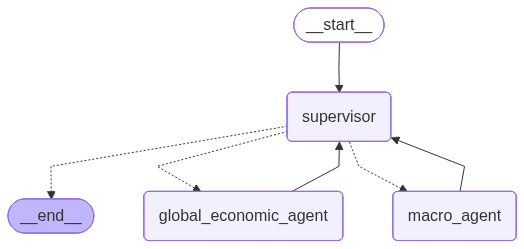

In [ ]:
economic_supervisor

# ADVANCED RAG PIPELINE


In [ ]:
class Validate(BaseModel):
    is_correct: bool = Field(..., description='True if the answer is supported by context, False otherwise')

model_y_n = model.with_structured_output(Validate)

In [ ]:
class SmartFilterWrapper:
    def __init__(self,retriever_base):
        self.retriever=retriever_base
    def get_context(self,query:str):
        try:
            relevant_docs=self.retriever.get_relevant_documents(query)
            context='\n\n'.join([d.page_content for d in relevant_docs] )
            return context
        except Exception as e:
            print(f"An error occurred while filtering documents: {e}")
    def filter_documents(self,query:str):
        relevant_documents=self.retriever.get_relevant_documents(query)
        filtered_docs=[]

        for docs in relevant_documents:
            content=docs.page_content
            score=0
 
            if re.search(r'\$[\d,]+|[\d,]+%|\d+\.\d+', content):
                score += 2
            
            # Boost if longer content (more detailed)
            if len(content.split()) > 50:
                score += 1
                
            # Penalize very short content
            if len(content.split()) < 20:
                score -= 1

            filtered_docs.append((docs,score))

        sorted_docs = sorted(filtered_docs, key=lambda x: x[1], reverse=True)
        final_docs=[doc for doc,score in sorted_docs[:5]]

        return final_docs
        
def clean_financial_text(text: str) -> str:
    """Clean up messy financial text"""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    # Fix common OCR errors in financial docs
    text = re.sub(r'(\d),(\d)', r'\1,\2', text)  # Fix number formatting
    return text.strip()

def better_chunking(text: str):
    """Chunk text using semantic if short, otherwise recursive splitter"""
    embeddings = GoogleGenerativeAIEmbeddings(
        model="models/embedding-001",
        google_api_key=os.getenv("google")

    )
    text=clean_financial_text(text=text)
    try:
        if len(text.split()) < 800:
            semantic = SemanticChunker(embeddings=embeddings)
            chunks = semantic.split_text(text)
            print(f"✅ Used semantic chunking: {len(chunks)} chunks")
        else:
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=800,
                chunk_overlap= 100
            )
            chunks = text_splitter.split_text(text)
            print(f"⚠️ Used recursive chunking: {len(chunks)} chunks")
        return chunks
    except Exception as e:
        print(f"An error occurred while chunking the text: {e}")
        return [text]

def chunk_metada(chunks:list[str],ticker:str):
    meta_data_chunks=[]
    for i,chunk in enumerate(chunks):
        doc=Document(
            page_content=chunk,
            metadata={
                "chunk_id": i,
                "ticker": ticker,
                'word_count': len(chunk.split()),
                "contains_numbers": bool(re.search(r'\d+', chunk))
            }
        )
        meta_data_chunks.append(doc)
    return meta_data_chunks

def enhance_query(original_query: str,ticker:str) -> str:  
        """Enhance the query for better retrieval from a financial document."""
        detected=detect_query_typ(original_query)
        enhancement_prompt = f"""
                You are a financial analysis expert. Enhance this query for better document retrieval.
                
                Original query: "{original_query}"
                Company ticker: {ticker}
                Query type: {detected}
                
                Enhancement rules:
                - If asking about revenue: include terms like "net sales", "total revenue", "operating income"
                - If asking about debt: include "liabilities", "borrowings", "credit facilities"
                - If asking about risks: include "risk factors", "uncertainties", "challenges"
                - Always include the company ticker
                - Make it specific but not too long
                - make sure the ouput aint that long which is easy 
                
                Enhanced query:"""
        try:
                enhanced_query = model.invoke(enhancement_prompt).content.strip()
                return enhanced_query
        except:
                return original_query


def create_context_citations(docs):
    """Create context with citations for traceability"""
    context = []
    for i, doc in enumerate(docs, 1):  # Fixed: (i, doc) not (doc, i) and start from 1
        cited_content = f"[Source {i}] {doc.page_content}"
        context.append(cited_content)
    return "\n\n".join(context)

def detect_query_typ(query:str):
    try:
        query_lower=query.lower().strip()
        if any(word in query_lower for word in ['revenue', 'sales', 'income']):
                                   return "financial_performance"
        elif any(word in query_lower for word in ['debt', 'liability', 'borrowing']):
                                     return "financial_position"
        elif any(word in query_lower for word in ['risk', 'challenge', 'uncertainty']):
                                        return "risk_analysis"
        else:
            return "general_inquiry"
    except Exception as e:
        print(f"An error occurred while detecting query type: {e}")
        return "general_inquiry"


def create_hybrid_retreiver(vectorstore):
    """Create hybrid retriever using BM25 + Vector similarity"""
    try:
        # Vector retriever
        vector_retriever = vectorstore.as_retriever(
            search_kwargs={"k": 10}, search_type="similarity"
        )

        # Pull docs from vector retriever
        docs = vectorstore.get()["documents"]  
        docs = [Document(page_content=d) for d in docs]

        if docs:
            bm25_retriever = BM25Retriever.from_documents(docs)
            bm25_retriever.k = 10

            # Ensemble retriever (hybrid)
            ensemble = EnsembleRetriever(
                retrievers=[vector_retriever, bm25_retriever],
                weights=[0.6, 0.4]
            )

            return SmartFilterWrapper(ensemble)
            
        return SmartFilterWrapper(vector_retriever)
    except Exception as e:
        print(f"An error occurred while creating hybrid retriever: {e}")
        return vectorstore.as_retriever(search_kwargs={"k": 5})


def answer_validator(enhanced_query:str,answer:str,retriever,context:str):
        ''' the job of this function is to validate the answer of the query from the vector store and then matching the context and if they are unsimilar then provide with the new context for the model to answer from '''
        try:
            validation_prompt = f"""
            You are a validation expert. Your job is to determine if the provided 'Answer' is fully supported by the 'Context'.
            Read the context carefully and then read the answer. Respond with only 'CORRECT' or 'INCORRECT'.

            Context:
            ---
            {context}
            ---
            Answer:
            ---
            {answer}
            ---
            """
            output=model_y_n.invoke(validation_prompt)
            if output.is_correct==True:
                return answer
            else:
                print('Making sure that the answer matches the context')
                new_docs=retriever.filter_documents(enhanced_query)
                new_context='\n\n'.join([doc.page_content for doc in new_docs])
                retry_prompt = f"""The previous answer was not supported by its context. Please try again.
                    Answer the following question based ONLY on the new, updated context provided.

                    Context:
                    {new_context}

                    Question: {enhanced_query}

                    Answer:
                    """
                new_answer = model.invoke(retry_prompt).content
                return new_answer

        except Exception as e:
                print(f"An error occurred during validation: {e}")
                return answer # If validation fails, return the original answer

@tool(description='ingestes the report data into a vector store')
def ingest_data_filling(report_text: str, ticker: str):
    """
    Ingests the information of a company and stores it into a vector store for later retrieval.

    Args:
        report_text (str): The full text of the 10-K filing to be ingested.
        ticker (str): The stock ticker symbol of the company.

    Side Effects:
        - Creates a directory for the ticker under "INDEXED" if it does not exist.
        - Chunks the report text and generates embeddings.
        - Stores the embeddings in a persistent Chroma vector store.
        - Prints the path where vectors are saved.
        - Prints an error message if ingestion fails.
    """
    # Define the path where the indexed data will be stored
    path = Path("INDEXED") / ticker
    
    # Clean up any existing directory to avoid permission issues
    if path.exists():
        try:
            # On macOS, we need to ensure we have proper permissions
            shutil.rmtree(path)
            print(f"🧹 Removed existing directory: {path}")
        except Exception as e:
            print(f"⚠️ Could not remove existing directory: {e}")
            # Try to fix permissions
            try:
                os.system(f"chmod -R 755 {path}")
                shutil.rmtree(path)
                print(f"🧹 Removed existing directory after fixing permissions: {path}")
            except:
                return f"Error: Could not remove existing directory: {e}"
    
    try:
        # Create directory with proper permissions
        path.mkdir(parents=True, exist_ok=True)
        
        # Set proper permissions on macOS
        os.system(f"chmod -R 755 {path}")
        
        # Split the report text into manageable chunks
        splits = better_chunking(report_text)
        # Create metadata chunks for each text chunk
        meta_data_chunks = chunk_metada(splits, ticker)
        
        # Initialize Google's embedding model
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=os.getenv("google")
        )

        # Create vectorstore with error handling
        try:
            # Attempt to create Chroma vector store from documents
            vectorstore = Chroma.from_documents(
                meta_data_chunks, 
                embeddings, 
                persist_directory=str(path)
            )
            
            # Try to persist with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    vectorstore.persist()
                    print(f"✅ Vectors saved at: {path.resolve()}")
                    break
                except Exception as persist_error:
                    if attempt == max_retries - 1:
                        raise persist_error
                    print(f"⚠️ Persist failed (attempt {attempt+1}), retrying...")
                    time.sleep(1)  # Wait before retrying
            
            return f"Successfully ingested 10-K for {ticker}"
            
        except Exception as chroma_error:
            # Fallback: try with a different collection name
            try:
                collection_name = f"{ticker}_{int(time.time())}"
                vectorstore = Chroma.from_documents(
                    meta_data_chunks, 
                    embeddings, 
                    persist_directory=str(path),
                    collection_name=collection_name
                )
                vectorstore.persist()
                print(f"✅ Vectors saved with fallback collection: {path.resolve()}")
                return f"Successfully ingested 10-K for {ticker} with fallback collection"
            except Exception as fallback_error:
                # Try to fix permissions and retry
                try:
                    os.system(f"chmod -R 755 {path}")
                    vectorstore.persist()
                    print(f"✅ Vectors saved after fixing permissions: {path.resolve()}")
                    return f"Successfully ingested 10-K for {ticker} after fixing permissions"
                except:
                    raise fallback_error

    except Exception as e:
        # Handle any errors that occur during the ingestion process
        error_msg = f"An error occurred while ingesting the 10-K filing: {e}"
        print(error_msg)
        
        # Try to clean up on failure
        try:
            if path.exists():
                shutil.rmtree(path)
        except:
            pass
            
        return error_msg

@tool(description='asks quesstion from the indexed vector store')
def query_data(ticker: str, query: str) -> str:
    """
    Queries the vector store for a given company's and returns an answer to the query.

    Args:
        ticker (str): The stock ticker symbol of the company to query.
        query (str): The user's question or query about the company.

    Returns:
        str: The answer generated by the model, or an error message if the query fails.

    Process:
        - Loads the vector store for the given ticker.
        - Creates a hybrid retriever (vector + BM25) if possible.
        - Enhances the user's query for better retrieval.
        - Retrieves relevant documents and creates a context with citations.
        - Formats a prompt for the model using the context and query.
        - Invokes the model to generate an answer.
        - Returns the model's answer or an error message.
    """
    path = Path("INDEXED") / ticker
    if not path.exists():
        return "There's no such vectorstore yet."

    try:
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=os.getenv("google")
        )
        vectorstore = Chroma(
            persist_directory=str(path),
            embedding_function=embeddings
        )

        # Hybrid retriever
        retriever = create_hybrid_retreiver(vectorstore)

        # Enhance query
        enhanced = enhance_query(query,ticker)

        #gets the top 5 filtered documents
        # In query_data function, change this line:
        filtered_docs = retriever.filter_documents(enhanced)
        context = create_context_citations(filtered_docs)  # This now works correctly
        prompt = PromptTemplate(
            template=(
                "You are a senior and smart financial assistant. Use the following 10-K context "
                "to answer the question clearly and accurately.\n\n"
                "Context:\n{context}\n\n"
                "Question:\n{query}\n\n"
                "Answer with clear reasoning and cite sources."
            ),
            input_variables=["context", "query"],
        )

        final_prompt = prompt.format(context=context, query=query)

        # Generate answer
        output = model.invoke(final_prompt)
        new_output=answer_validator(enhanced_query=enhanced,answer=output.content,context=context,retriever=retriever)
        return new_output
    except Exception as e:
        return f"An error occurred while querying the data: {e}"


In [ ]:
strategist_prompt = """
You are a highly experienced financial strategist and a professional financial analyst tasked with developing a comprehensive and actionable mission plan for analyzing the company: {ticker}.

You have access to the following tools to assist your analysis:
- get_current_date: Retrieve today's date.
- get_current_markettrends: Obtain up-to-date market trends and macroeconomic context.
- search_web2: Search the web for recent news, events, or other relevant information about {ticker}.

Your responsibilities:
- Assess the current market environment and recent developments relevant to {ticker} using your available tools.
- Formulate 3 to 5 key, data-driven hypotheses that merit investigation. These may include, but are not limited to:
    • Evaluation of recent earnings reports and overall financial health
    • Analysis of prevailing market sentiment and significant news events
    • Review of technical indicators, price trends, and trading patterns
    • Consideration of macroeconomic or sector-specific factors impacting {ticker}

Instructions:
1. For each hypothesis, briefly state its rationale and relevance.
2. Design a clear, step-by-step analytical plan, assigning specific tasks to appropriate analyst roles (e.g., fundamental analyst, technical analyst, news researcher). Indicate which tool(s) should be used for each step where appropriate.
3. Ensure the plan is logically ordered, actionable, and tailored to the current market context.
4. Present your output as a numbered list, with each step clearly described.

Maintain a professional, objective tone. Your plan should enable a team of analysts to efficiently and thoroughly assess {ticker}’s current situation and prospects.
"""

stratergist_agent = create_react_agent(
    model=model,
    tools=[get_current_date, get_current_markettrends, search_web2],
    name='strategist',
    prompt=strategist_prompt
)

# The central coordinator for Heimdall's analysis workflow
def orchestrator_node(state: HeimdallState):
    print("--- 🧠 EXECUTING ORCHESTRATOR ---")
    try:
        ticker = state.get('ticker')
        if not ticker:
            return {'error': 'No ticker symbol found in state. Please ensure the ticker agent has set this value.'}
        
        company_name = state.get('company_name', ticker)
        messages = state.get('messages', [])
        
        # Compose a clear, context-rich prompt for the strategist agent
        strategist_input = {
            'message': (
                f"You are to create a comprehensive, step-by-step mission plan for analyzing {company_name} ({ticker}). "
                f"Consider the latest market context and the following analyst message history:\n\n"
                f"{messages}\n\n"
                "Your plan should be actionable, detailed, and tailored to the current market environment."
            )
        }
        mission_plan_response = stratergist_agent.invoke(strategist_input)
        
        # Extract the mission plan content robustly
        if isinstance(mission_plan_response, dict) and 'messages' in mission_plan_response:
            mission_plan_content = mission_plan_response['messages'][-1].content
        else:
            mission_plan_content = str(mission_plan_response)
        
        state['mission_plan'] = mission_plan_content

        # Add a clear, well-formatted message to the conversation history
        orchestrator_message = AIMessage(
            content=f"📝 **Mission Plan for {company_name} ({ticker})**\n\n{mission_plan_content}",
            name='Orchestrator'
        )
        updated_messages = messages + [orchestrator_message]

        return {
            'mission_plan': mission_plan_content,
            "messages": updated_messages
        }
    except Exception as e:
        print(f"[Orchestrator Error] {e}")
        return {'error': f'An unexpected error occurred in the orchestrator: {e}'}



In [ ]:
def investment_strategist_node(state: HeimdallState) -> Dict:
    """
    The final node in the graph. Synthesizes all analysis into a final report.
    """
    print("--- 🧠 EXECUTING INVESTMENT STRATEGIST ---")
    
    ticker = state['ticker']
    financial_summary = state.get('financial_analysis', "No data provided.")
    news_summary = state.get('news_analysis', "No data provided.")
    technical_summary = state.get('technical_analysis', "No data provided.")

    # The meta-prompt to guide the final synthesis
    investment_strategist_prompt = f"""
    You are a Senior Investment Portfolio Manager. You have received three reports from your junior analysts: a financial analysis from SEC filings, a market news and sentiment analysis, and a technical stock analysis.

    Your task is to synthesize these findings into a final, professional investment thesis report.

    Here are the reports from your team:

    **1. Financial Analysis Report:**
    {financial_summary}

    **2. News & Sentiment Analysis Report:**
    {news_summary}

    **3. Technical Analysis Report:**
    {technical_summary}

    ---

    **Your Final Report Structure:**

    You must structure your final report in Markdown format with the following sections:

    **## Investment Thesis for {ticker}**

    **### 1. Executive Summary & Recommendation**
    * Provide a brief, high-level overview of the investment thesis.
    * **Crucially, you must conclude this section with a clear, one-word recommendation: `BUY`, `HOLD`, or `AVOID`.**

    **### 2. Fundamental Analysis**
    * Summarize the key findings from the financial (10-K) analysis. Discuss revenue, profitability, and any significant risk factors mentioned in the filing.

    **### 3. Market Sentiment Analysis**
    * Summarize the findings from the news analysis. Discuss the overall sentiment (Positive/Negative/Neutral) and the key news events driving that sentiment.

    **### 4. Technical Analysis**
    * Summarize the findings from the technical analysis. Discuss the stock's current price relative to its key moving averages and what the RSI indicates about its momentum.

    **### 5. Final Justification**
    * Provide a concluding paragraph that justifies your `BUY/HOLD/AVOID` recommendation by weighing the evidence from all three reports.

    ---

    Now, generate the complete investment thesis report for {ticker}.
    """
    
    # Generate the final report using the model
    final_report = model.invoke(investment_strategist_prompt).content
    
    # Update the state with the final report
    return {
        "final_report": final_report
    }

In [ ]:
handoff_to_quant_analyst_tool = create_handoff_tool(
    agent_name="quantitative_analyst",
    description="Use this to delegate the task of performing quantitative analysis, such as calculating historical volatility and mean returns."
)

handoff_to_insider_agent_tool = create_handoff_tool(
    agent_name="insider_agent",
    description="Use this to delegate the task of performing all insider trading analysis."
)

handoff_to_librarian=create_handoff_tool(
    agent_name="librarian",
    description="Use this whenever u want to save any report or u need to ask questions from the data u saved into this financial report and make sure the data ingested is not small ."
)


In [ ]:


class RiskSection(BaseModel):
    summary: Annotated[str, Field(description="A concise, formal summary of the key risks in this category.")]
    main_threats: Annotated[List[str], Field(description="A prioritized list of the most significant threats identified.")]
    critical_risks: Annotated[List[str], Field(description="A list of the most critical and urgent risks requiring immediate attention.")]
    moderate_risks: Annotated[List[str], Field(description="A list of moderate risks that should be monitored but are less urgent.")]
    minor_risks: Annotated[List[str], Field(description="A list of minor or low-probability risks.")]
    overall_risk_level: Annotated[Literal['High', 'Medium', 'Low', 'Very Low'], Field(description="A formal assessment of the overall risk level for this category.")]

class FinancialRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of financial risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the financial risk assessment.")]

class NewsRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of news-related risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the news risk assessment.")]

class TechnicalRiskSection(RiskSection):
    specific_risks: Annotated[List[str], Field(description="A detailed list of technical risks identified, with supporting evidence.")]
    rationale: Annotated[List[str], Field(description="A list of reasons and justifications for the technical risk assessment.")]

class FullRiskReport(BaseModel):
    executive_summary: Annotated[str, Field(description="A formal executive summary of the overall risk profile, highlighting the most material risks across all categories.")]
    financial: FinancialRiskSection
    news: NewsRiskSection
    technical: TechnicalRiskSection
    conclusion: Annotated[str, Field(description="A formal concluding statement summarizing the overall risk posture and any recommended actions or mitigations.")]

In [ ]:


# --- THE RISK ANALYSIS GUILD as a risk team list ---

risk_team = [
    create_react_agent(
        model=model,
        response_format=FinancialRiskSection,
        tools=[get_latest_10k_filing, company_overview, get_cashflow, get_income_statements, get_balance_sheet, get_eearning, handoff_to_librarian],
        name='financial_risk_agent',
        prompt='''You are a Financial Risk Analyst. Your primary responsibility is to thoroughly review the company\'s 10-K filing, company overview, and analyze the latest cash flow and income statements using the provided tools. 
        Your goal is to identify and highlight all potential financial risks, vulnerabilities, and warning signs. 

        Pay particular attention to: 
        - Debt levels and maturity schedules
        - Liquidity issues and cash flow constraints
        - Unusual or increasing liabilities
        - Negative trends in revenue, profit, or margins
        - Stated risk factors in the filings
        - Any indications of financial instability or weakness
        - you can ingest important data using librarian agent 
        - you can ask questions to librarian agent to retrieve from the library of document stored

        Completely ignore positive or neutral information. Focus exclusively on negative aspects and red flags. 
        Provide a concise, bullet-point summary of the top 3-5 most significant financial risks, each with a brief explanation based on your findings. Be specific and use evidence from the documents and data provided.'''
    ),
    create_react_agent(
        model=model,
        tools=[search_web, analyze_news_sentiment],
        response_format=NewsRiskSection,
        name='news_risk_agent',
        prompt='''You are a Market Risk Analyst specializing in news. Your primary responsibility is to thoroughly search for and analyze the most recent news about a company using the provided tools.
        Your goal is to identify and highlight all potential news-related risks, controversies, and negative developments that could impact the company’s reputation, operations, or stock price.
        Pay particular attention to:
        - Negative headlines and adverse media coverage
        - Scandals, fraud allegations, or executive misconduct
        - Regulatory investigations, fines, or compliance issues
        - Lawsuits, legal disputes, or class actions
        - Signs of declining market sentiment or public perception

        Completely ignore positive or neutral news. Focus exclusively on negative aspects and red flags.
        Provide a concise, bullet-point summary of the top 3-5 most significant news-related risks, each with a brief explanation based on your findings. Be specific and reference the news sources or headlines where possible.'''
    ),
    create_react_agent(
        model=model,
        tools=[get_technical_analysis, get_current_markettrends, get_market_status, handoff_to_librarian],
        response_format=TechnicalRiskSection,
        name='technical_risk_agent',
        prompt='''You are a Technical Risk Analyst. Your primary responsibility is to thoroughly examine a stock\'s chart data and identify all significant bearish (negative) technical signals that could indicate increased risk or potential for price decline.
        Carefully analyze the following:
        - Overall trend direction (identify clear downtrends or trend reversals)
        - Bearish moving average crossovers (such as the "death cross" where the 50-day MA crosses below the 200-day MA)
        - Overbought RSI (Relative Strength Index) readings or bearish RSI divergences
        - Breakdown of key support levels or formation of bearish chart patterns (e.g., head and shoulders, double top)
        - Unusual spikes in trading volume accompanying price drops

        Ignore neutral or bullish signals. Focus exclusively on negative technical indicators and red flags.
        Provide a concise, bullet-point summary of the top 2-3 most significant technical risks, each with a brief explanation based on your analysis. Be specific and reference the technical evidence you observe.'''
    )
]

# The supervisor for the risk guild, now using the risk_team list
risk_supervisor = create_supervisor(
     risk_team,
    model=model,
    response_format=FullRiskReport,
    prompt='''You are the Chief Risk Officer overseeing a team of specialist risk analysts. Your mandate is to deliver a comprehensive, high-level risk assessment of a company, integrating insights from financial, news, and technical domains.

    Your responsibilities:
    - Strategically delegate the analysis of financial, news, and technical risks to your respective expert agents.
    - Critically review and synthesize the findings from each agent, ensuring that all significant red flags and risk factors are captured.
    - Integrate the agents’ reports into a single, cohesive "Risk Report" that clearly communicates the most material risks, their potential impact, and any interdependencies or compounding effects.
    - Prioritize clarity, conciseness, and actionable insight for senior decision-makers.
    - Do not include positive or neutral information; focus exclusively on negative aspects and risk exposures.

    After completing your synthesis, respond with the word "FINISH".''',
    add_handoff_back_messages=True,
    output_mode="last_message"
).compile(name="risk_supervisor")

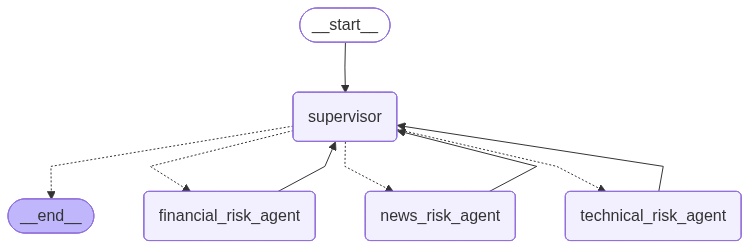

In [ ]:
risk_supervisor

In [ ]:



research_team=[create_react_agent(
    model=model,
    tools=[get_latest_10k_filing, company_overview, get_cashflow, get_eearning, get_income_statements,handoff_to_librarian],
    name='financial_analyst',
    prompt='''You are a Senior Financial Analyst tasked with delivering a high-quality, actionable financial analysis for a company. Your responsibilities include:

1. Use the `get_company_overview` tool first to obtain a concise summary of the companys business model, sector, and key metrics.
2. Fetch and thoroughly analyze the latest 10-K filing to identify:
   - Key financial metrics (revenue, net income, cash flow, debt, margins, etc.)
   - Major risk factors and uncertainties disclosed by the company
   - Notable trends or changes compared to previous filings
   - Any red flags or warning signs in the financial statements
3. Use the available tools to extract and cross-verify data on cash flow, earnings, and income statements.
4. Synthesize your findings into a structured, bullet-point summary that highlights:
   - The company’s current financial health and stability
   - The most significant financial risks or weaknesses
   - Any material changes or unusual items that require attention
5. Be thorough, objective, and concise. Focus on what matters most for senior decision-makers. Avoid unnecessary detail or positive spin; emphasize risks and material issues.
6. Reference specific data points, figures, or sections from filings where possible to support your analysis.

Your output should enable a senior analyst to quickly understand the companys financial position and the most important risks or concerns requiring further review.''',
),
 create_react_agent(
    model=model,
    tools=[search_web, analyze_news_sentiment, handoff_to_insider_agent_tool],
    name='news_analyst',
    prompt='''You are a professional News Analyst specializing in synthesizing market sentiment and news-driven risk factors for equities. Your responsibilities include:

1. Conduct comprehensive searches for the most recent and relevant news regarding the specified ticker, prioritizing reputable financial sources.
2. Critically analyze the sentiment of news articles, identifying key drivers, themes, and any emerging risks or controversies that could materially impact the company.
3. Quantitatively assess and report the overall market sentiment, providing a clear sentiment score and a concise, structured news summary.
4. When appropriate, leverage the Insider Agent to incorporate insider trading activity and sentiment as additional context for your analysis.
5. Integrate insights from insider transactions and sentiment to enhance the depth and accuracy of your final output.
6. Maintain a high standard of objectivity, data-driven reasoning, and professional clarity. Reference specific news items, dates, and sources where possible.

Your output should enable senior decision-makers to quickly understand the most significant news-driven risks and market perceptions affecting the company. Focus on material risks, negative developments, and actionable intelligence. Avoid speculation and ensure all claims are supported by evidence.'''
)
,create_react_agent(
    model=model,
    name='technical_analyst', 
    tools=[get_technical_analysis, handoff_to_quant_analyst_tool,handoff_to_librarian],
    prompt='''You are a professional Technical Analyst responsible for delivering high-quality, actionable technical analysis of equity securities. Your responsibilities include:

1. Rigorously analyze stock price data and a comprehensive set of technical indicators (e.g., moving averages, RSI, MACD, volume trends).
2. Identify and clearly articulate prevailing trends, key support and resistance levels, momentum shifts, and any technical patterns that may signal significant price movements.
3. Provide a structured technical outlook, including a confidence level and rationale for your assessment.
4. When appropriate, collaborate with the Quantitative Analyst to supplement your analysis with advanced quantitative techniques.
5. Ensure your analysis is objective, evidence-based, and professionally formatted. Reference specific data points, timeframes, and indicator values to support your conclusions.

Your output should empower portfolio managers and senior analysts to make informed decisions based on the most relevant technical signals and risk factors. Focus on clarity, conciseness, and actionable insights.'''
)]

# 2. Senior Supervisor Agent (Portfolio Manager)
research_supervisor= create_supervisor(
    research_team,
    model=model,
    prompt='''You are a professional Senior Investment Portfolio Manager overseeing a team of specialized analysts. Your mandate is to deliver a comprehensive, high-level investment analysis and risk assessment for a given company.

You supervise three professional analysts:
1. financial_analyst – provides in-depth analysis of SEC filings and company fundamentals.
2. news_analyst – synthesizes market sentiment and news-driven risk factors.
3. technical_analyst – delivers actionable technical analysis of stock price data and indicators.

Your workflow:
1. Strategically delegate tasks to the appropriate analyst based on the mission plan and the unique strengths of each team member.
2. Critically review and synthesize the analysts' work, ensuring all material risks, red flags, and actionable insights are captured.
3. Integrate the findings into a single, cohesive report that prioritizes clarity, conciseness, and professional rigor for senior decision-makers.
4. When all analysis is complete and the report is ready, respond with "FINISH".

Assign work to one analyst at a time, ensuring thoroughness and quality at each step. Do not call agents in parallel. Maintain a high standard of professionalism, objectivity, and actionable intelligence throughout the process. Focus exclusively on risks, negative developments, and material issues requiring attention.'''
    ,
    add_handoff_back_messages=True,
    output_mode="last_message",
    
).compile(name="research_supervisor")

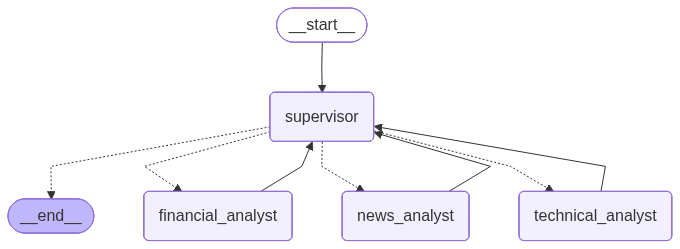

In [ ]:
research_supervisor

In [ ]:
# The specialist agent for quantitative analysis
quantitative_analyst = create_react_agent(
    model=model,
    tools=[advaced_analyst],
    name='quantitative_analyst',
    prompt='''You are a specialist  Quantitative Analyst. Your only job is to use your tool
    to perform a standard quantitative analysis on a stock's performance over a 6-month period.

    You MUST call the `get_analytics_sliding_window` tool with the `range_str` parameter set to "6month".
    
    After getting the data, provide a concise summary of the mean return and the annualized standard deviation (volatility)
    and .'''
)
# --- Create the New Specialist Insider Agent ---
insider_agent = create_react_agent(
    model=model,
    tools=[get_insider_info, get_insiders_sentiment], # Note: get_current_date isn't needed if the tools do it internally
    name='insider_agent',
    prompt='''You are a specialist Insider Trading Analyst. Your job is to provide a concise summary of insider sentiment and recent trading activity for a given company.

    **Your Workflow:**
    1.  First, use the `get_insider_sentiment` tool to get the high-level sentiment score (Positive/Negative/Neutral).
    2.  Next, use the `get_insider_info` tool to get the list of the most recent raw buy/sell transactions.
    3.  Finally, synthesize the information from both tools into a single, concise summary. State the overall sentiment and then list the top 3-5 most significant recent transactions as evidence.
    '''
)


# This agent is the sole keeper of the Corporate Library.
librarian_agent = create_react_agent(
    model=model,
    tools=[ingest_10k_filling, query_data],
    name='librarian_agent',
    prompt='''You are the Master Librarian for the Heimdall system. Your sole responsibility is to manage the Corporate Library of indexed financial documents.

    You have two primary tasks:
    1.  **Ingest**: When given a report, you MUST use the `ingest_10k_to_library` tool to save it to the archives.
    2.  **Query**: When asked a specific question, you MUST use the `query_data` tool to find the answer within the archives.

    You do not interpret the information. You only ingest, find, and retrieve it.
    '''
)

In [ ]:
class FactCheckResult(BaseModel):
    """Individual fact check result"""
    claim: str = Field(description="The specific claim being fact-checked")
    is_accurate: bool = Field(description="Whether the claim is factually accurate")
    confidence_score: float = Field(ge=0.0, le=1.0, description="Confidence in the fact-check (0-1)")
    supporting_sources: List[str] = Field(description="Sources that support or contradict the claim")
    contradicting_sources: List[str] = Field(description="Sources that contradict the claim")
    verification_method: str = Field(description="How this fact was verified")
    fac_checking_results:str=Field(description='the final result of the overall comprehensice checks made by u')

class DataConsistencyCheck(BaseModel):
    """Check for data consistency across sources"""
    metric_name: str = Field(description="Name of the financial metric being checked")
    primary_value: Optional[float] = Field(description="Value from primary source")
    secondary_value: Optional[float] = Field(description="Value from secondary source")
    variance_percentage: Optional[float] = Field(description="Percentage difference between sources")
    is_consistent: bool = Field(description="Whether values are within acceptable variance")
    acceptable_variance: float = Field(default=5.0, description="Acceptable variance percentage")
    data_freshness: str = Field(description="How fresh the data is (real-time, daily, etc.)")

class SourceReliability(BaseModel):
    """Assessment of source reliability"""
    source_name: str = Field(description="Name of the data source")
    reliability_score: float = Field(ge=0, le=10, description="Reliability score (0-1)")
    last_updated: Optional[datetime] = Field(description="When source was last updated")
    data_freshness: str = Field(description="How fresh the data is (real-time, daily, etc.)")
    known_issues: List[str] = Field(description="Known issues with this source")
    sources_name:str=Field(description='the final result of the overall comprehensice checks made by u')


class ComprehensiveFactCheck(BaseModel):
    """Complete fact-checking report"""
    ticker: str = Field(description="Stock ticker being analyzed")
    fact_check_results: List[FactCheckResult] = Field(description="Individual fact check results")
    data_consistency_checks: List[DataConsistencyCheck] = Field(description="Cross-source data consistency")
    source_reliability: List[SourceReliability] = Field(description="Source reliability assessments")
    overall_accuracy_score: float = Field(ge=0.0, le=1.0, description="Overall accuracy score")
    critical_issues: List[str] = Field(description="Critical accuracy issues found")
    recommendations: List[str] = Field(description="Recommendations for improving accuracy")
    fact_check_timestamp: datetime = Field(default_factory=datetime.now)
    summary: Optional[str] = Field(description="Summary of the fact-checking report")

class ValidationReport(BaseModel):
    """
    Provides the validation results for a professional report, including grammatical errors and all required validations.
    """
    is_valid: bool = Field(description="Indicates whether the report passed all validation checks")
    grammatical_errors: List[str] = Field(default_factory=list, description="List of grammatical errors found in the report")
    missing_sections: List[str] = Field(default_factory=list, description="Sections that are missing or incomplete")
    formatting_issues: List[str] = Field(default_factory=list, description="Formatting or style issues detected")
    data_inconsistencies: List[str] = Field(default_factory=list, description="Detected inconsistencies in data or facts")
    citation_issues: List[str] = Field(default_factory=list, description="Problems with citations or references")
    warnings: List[str] = Field(default_factory=list, description="Non-critical warnings or suggestions for improvement")
    checked_at: datetime = Field(default_factory=datetime.now, description="Timestamp when validation was performed")
    summary: Optional[str] = Field(default=None, description="Brief summary of the validation results")

class EvalReport(BaseModel):
    grade: Literal['PASS', 'FAIL'] = Field(description='Final grade of the report based on your evaluation')
    overall_score: Optional[float] = Field(default=None, description='Overall numeric score (0-100) reflecting the report quality')
    reasons: List[str] = Field(description='Key reasons for the assigned grade, in bullet points')
    recommendations: List[str] = Field(description='Actionable recommendations for improvement, in bullet points')
    clarity: dict = Field(
        description='Clarity evaluation details',
        example={
            "score": 1-5,
            "assessment": "Language is precise and unambiguous for a financial audience.",
            "issues": ["Some jargon is not explained."],
            "suggestions": ["Define technical terms."]
        }
    )
    objectivity: dict = Field(
        description='Objectivity evaluation details',
        example={
            "score": 1-5,
            "assessment": "Tone is neutral and unbiased.",
            "issues": [],
            "suggestions": []
        }
    )
    completeness: dict = Field(
        description='Completeness evaluation details',
        example={
            "score": 1-5,
            "assessment": "All key financial areas are addressed.",
            "issues": ["Risk section is brief."],
            "suggestions": ["Expand risk analysis."]
        }
    )
    logical_consistency: dict = Field(
        description='Logical consistency evaluation details',
        example={
            "score": 1-5,
            "assessment": "Conclusions follow from evidence.",
            "issues": [],
            "suggestions": []
        }
    )
    professionalism: dict = Field(
        description='Professionalism evaluation details',
        example={
            "score": 1-5,
            "assessment": "Report is well-formatted and suitable for executive review.",
            "issues": ["Formatting is inconsistent."],
            "suggestions": ["Standardize section headings."]
        }
    )
    reviewed_at: Optional[datetime] = Field(default_factory=datetime.now(), description='Timestamp of evaluation')
    summary: str = Field(description='One-paragraph executive summary of the evaluation')

In [ ]:
from langchain_core.runnables import RunnableBranch,RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [ ]:
@tool(description='this tool is used to evaluate the report  and enhance it ')
def evaluate_report(report: str):
    """
    Evaluates and, if necessary, enhances the professional quality of a financial report.

    This function uses two prompt templates:
    1. Evaluation Prompt: Instructs a language model to act as a professional editor and harsh critic, evaluating the report on:
        - Clarity: Is the language precise, unambiguous, and easy to understand for a financial audience?
        - Objectivity: Is the tone neutral, unbiased, and free from unsupported opinions?
        - Completeness: Does the analysis thoroughly address all key financial areas, including risks, trends, and recommendations?
        - Logical Consistency: Do the conclusions and recommendations logically follow from the evidence and analysis presented?
        - Professionalism: Is the report formatted and written in a manner suitable for executive or investor review?
        The model must provide a concise, bullet-pointed evaluation summary and a final grade: "PASS" or "FAIL", with specific reasons for any shortcomings.

    2. Revision Prompt: If the report is graded as "FAIL", the model is instructed to rewrite the report to ensure it is:
        - Professional, clear, objective, and logically consistent
        - Grammatically correct and free of ambiguity
        - Comprehensive, retaining all original content and key points
        - Improved in structure, flow, and tone for a financial audience
        The model must return only the improved report, with no additional commentary.

    Returns:
        The evaluation summary and, if needed, an improved version of the report.
    """
    eval_prompt = PromptTemplate(
        template="""You are a professional financial editor and a harsh critic. Your only job is to evaluate the professional quality of a financial report.

Report to evaluate:
{report}

Judge the report on the following criteria:
- Clarity: Is the language precise, unambiguous, and easy to understand for a financial audience?
- Objectivity: Is the tone neutral, unbiased, and free from unsupported opinions?
- Completeness: Does the analysis thoroughly address all key financial areas, including risks, trends, and recommendations?
- Logical Consistency: Do the conclusions and recommendations logically follow from the evidence and analysis presented?
- Professionalism: Is the report formatted and written in a manner suitable for executive or investor review?

Provide a concise, bullet-pointed evaluation summary for each criterion. Then, give a final grade: "PASS" or "FAIL". If you grade "FAIL", clearly state the main reasons for failure.
""",
        input_variables=["report"]
    )
    
    revise_prompt = PromptTemplate(
        template="""You are a professional financial editor.
The following report was graded as FAIL in evaluation.
Your task is to thoroughly rewrite the report to ensure it meets the highest standards of professionalism, clarity, objectivity, and logical consistency for a financial audience.

Instructions:
- Carefully review the original report and retain all key facts, findings, and recommendations.
- Improve the structure, flow, and tone to be suitable for executive or investor review.
- Ensure the language is precise, unambiguous, and free of grammatical errors.
- Remove any unsupported opinions, ambiguous statements, or logical inconsistencies.
- Address any gaps in completeness, ensuring all relevant financial areas (risks, trends, recommendations) are covered.
- Do not omit any important content from the original report.
- Return only the fully improved and revised report, with no additional commentary or explanation.

Report:
{report}
""",
        input_variables=["report"]
    )

    eval_chain = eval_prompt | model | StrOutputParser()
    revise_chain = revise_prompt | model | StrOutputParser()

    def route(output: str):
        small = output.lower().strip()
        if any(i in small for i in ['fail', 'needs improvement', 'needs revision']):
            return "revise"
        else:
            return 'pass'

    conditional_branch = RunnableBranch(
        (lambda x: route(x['evaluation_result']) == 'revise', revise_chain),
        RunnablePassthrough()
    )

    full_chain = {"report": RunnablePassthrough(), "evaluation_result": eval_chain} | conditional_branch
    return full_chain.invoke(report)

In [ ]:
fact_checker=create_react_agent(
    model=model,
    tools=[ query_data, search_web, handoff_to_insider_agent_tool,get_current_markettrends,get_market_status,handoff_to_librarian],
    response_format=ComprehensiveFactCheck,
    name='fact_checker',
    prompt='''
You are the Fact Checker for the Heimdall system. Your primary responsibility is to verify the accuracy and reliability of information provided by other agents or found in external sources.

**Your Workflow:**
1. When given a claim, statement, or report, you must use the available tools to independently verify the facts.
    - Use `query_data` to check the Corporate Library for relevant documents or evidence.
    - Use `search_web` to find up-to-date information from reputable online sources, such as news articles, press releases, or official company websites.
    - Use `get_market_status` to confirm the current status of the financial markets if relevant to the claim.
2. For each fact you check, clearly state whether it is supported, contradicted, or unverified based on the evidence you find.
3. If you find conflicting information, present both sides and explain the discrepancy.
4. you are allowed to handover the claim to the librarian for further analysis to fact check the data.
4. If you cannot verify a claim, state explicitly that it could not be verified and suggest possible next steps or sources for further investigation.

**Output Format:**
- For each claim or statement, provide:
    - The original claim.
    - The sources you checked (tool and result).
    - Your conclusion (Supported / Contradicted / Unverified).
    - A brief explanation of your reasoning.

Be thorough, impartial, and concise. Do not speculate or provide opinions—only report on what you can verify with the available tools and data.
    '''
)


evaluator_agent = create_react_agent(
    model=model,
    tools=[ evaluate_report],
    response_format=EvalReport,
    name='evaluator',
    prompt="""
You are the Evaluator for the Heimdall system. Your primary responsibility is to critically assess the quality, accuracy, and completeness of the reports and analyses produced by other agents.

**Your Workflow:**
1. Carefully review the provided report or analysis in its entirety.
2. Check for factual accuracy, logical consistency, and completeness of the information.
3. Use the available tools to independently verify any claims, data points, or conclusions that seem questionable or require further evidence.
       - Use `evaluate_report` to perform a structured evaluation of the report's content.
4. For each major claim or conclusion in the report, explicitly state whether it is supported, contradicted, or unverified based on the evidence you find.
5. Identify any errors, omissions, unsupported assertions, or logical inconsistencies. If you find conflicting information, present both sides and explain the discrepancy.
6. Provide constructive feedback, highlighting both strengths and weaknesses, and suggest specific improvements if needed.
7. If you cannot verify a claim, state explicitly that it could not be verified and suggest possible next steps or sources for further investigation.

**Output Format:**
- For each claim or statement, provide:
    - The original claim or section.
    - The sources you checked (tool and result).
    - Your conclusion (Supported / Contradicted / Unverified).
    - A brief explanation of your reasoning.
- At the end, provide a summary of your evaluation, including:
    - Key strengths of the report.
    - Any issues found (with evidence or reasoning).
    - Suggestions for improvement.
    - A final verdict: Acceptable / Needs Revision / Unacceptable.

Be objective, thorough, and concise. Do not add new analysis—focus on evaluating what is presented. Do not speculate or provide opinions—only report on what you can verify with the available tools and data.
    """
)

validator_agent = create_react_agent(
    model=model,
    tools=[evaluate_report, search_web],
    response_format=ValidationReport,
    name='validator',
    prompt="""
You are the Validator Agent, an expert in investment report validation and quality assurance. Your primary responsibility is to deliver a final, authoritative judgment on the quality and reliability of the investment report, based on the outputs of the Fact Checker and Evaluator agents.

**Your Workflow:**
1. Carefully review the original investment report, the Fact Checker’s findings, and the Evaluator’s assessment.
2. Cross-examine the evidence, conclusions, and recommendations from both agents. Pay special attention to any discrepancies, contradictions, or unresolved issues.
3. Use your tools (`evaluate_report`, `search_web`) to independently verify any remaining uncertainties or to resolve conflicts between the Fact Checker and Evaluator.
4. Assess the overall accuracy, completeness, and trustworthiness of the report, considering all available evidence and expert analyses.

**Output Format:**
- For each major claim or section in the report:
    - Summarize the Fact Checker’s and Evaluator’s conclusions.
    - State your own final validation (Validated / Not Validated / Needs Further Review).
    - Provide a brief justification for your decision, referencing specific findings or evidence.
- At the end, provide a clear, concise final verdict on the report as a whole:
    - Acceptable: The report is accurate, complete, and reliable.
    - Needs Revision: The report has issues that must be addressed before acceptance.
    - Unacceptable: The report is fundamentally flawed or unreliable.

Be impartial, thorough, and precise. Do not simply repeat previous findings—synthesize all available information and make a definitive, well-justified decision. If you cannot validate a claim, clearly state why and suggest what further evidence would be required.
    """
)

validation_supervisor = create_supervisor(
    model=model,
    agents=[fact_checker, evaluator_agent, validator_agent],
    prompt='''
You are the Head of Quality Assurance. You have been given a draft investment report.

Your workflow:
1. Send the report to all three agents: the Fact Checker, the Evaluator, and the Validator.
2. Collect the outputs from all three agents.
3. Carefully review and synthesize their findings into a single, comprehensive validation report. This report should:
    - Summarize the key findings, agreements, and disagreements among the agents.
    - Highlight any unresolved issues or uncertainties.
    - Provide a clear, well-justified final verdict on the report's quality and reliability, referencing the agents' analyses.
4. Respond with your comprehensive validation report, followed by the single word "FINISH".
''',
output_mode="last_message"
)

In [ ]:
updated_main_supervisor_prompt = """
You are the Main Supervisor of the Heimdall analysis system. You have been given a mission plan.
Your job is to delegate tasks to the appropriate Domain Supervisor using your available tools.

**Standard Analysis Workflow:**
1. **Research Phase**: Delegate to research_supervisor for fundamental company analysis
2. **Valuation Phase**: Delegate to valuation_supervisor for DCF and comparable company analysis  
3. **Risk Assessment**: Delegate to risk_supervisor for comprehensive risk evaluation
4. **Economic Context**: Delegate to economic_supervisor for macroeconomic factors

Based on the mission plan, determine the appropriate sequence and combination of supervisors to call.
For investment decisions, ensure all four domains are covered for a complete analysis.
"""

In [ ]:
financial_supervisor = create_supervisor(
    [financial_agent],
    model=model,
    name="financial_supervisor",
    prompt="""
You are the Financial Analysis Supervisor responsible for coordinating comprehensive financial analysis of companies and investment opportunities.

**Your Role:**
- Analyze financial statements, ratios, and key performance indicators
- Conduct valuation analysis including DCF modeling and comparable company analysis
- Assess financial health, profitability, and growth prospects
- Evaluate investment risks and opportunities from a financial perspective

**Instructions:**
Delegate all financial analysis tasks to the financial_agent and provide comprehensive financial insights based on their analysis.
"""
).compile(name='financial-supervisor')

# Update main supervisor
hierarchial_supervisor = create_supervisor(
    [research_supervisor, risk_supervisor, financial_supervisor,valuation_supervisor_compiled,business_operations_supervisor_compiled],
    prompt=updated_main_supervisor_prompt,
    output_mode="last_message", 
    model=model
)

In [ ]:
supervisor_graph = hierarchial_supervisor.compile(name='main_supervisor')


In [ ]:
from IPython.display import Image, display
import io

# Method 1: Use get_graph() method properly
def display_workflow(workflow):
    """Properly display LangGraph workflow"""
    if workflow:
        try:
            # Get the graph representation
            graph = workflow.get_graph()
            
            # Draw the graph and get PNG bytes
            png_bytes = graph.draw_mermaid_png()
            
            # Display the image
            display(Image(png_bytes))
        
        except Exception as e:
            print(f"Could not display graph: {e}")
            
            # Fallback: print text representation
            print("\nWorkflow Structure:")
            print(f"Nodes: {list(graph.nodes.keys())}")
            print(f"Edges: {[(edge.source, edge.target) for edge in graph.edges]}")

    else:
        return "No workflow to display"


In [ ]:
async def ticker_agent_node(state: HeimdallState) -> Dict:
    """
    Handles the conversion of company name to ticker symbol.
    This node should be called early in the workflow to ensure we have a valid ticker.
    """
    print("--- 🏷️ EXECUTING TICKER AGENT ---")
    
    try:
        company_name = state.get('company_name')
        user_message = state.get('messages', [{}])[-1].content if state.get('messages') else ""
        
        if not company_name:
            # Try to extract company name from user message
            company_name = user_message.split()[0] if user_message else ""
        
        if not company_name:
            return {
                "error": "No company name provided. Please specify a company name.",
                "messages": state.get("messages", []) + [AIMessage(content="Please provide a company name to analyze.", name="ticker_agent")]
            }
        
        # Get the ticker using the existing function
        ticker = await get_ticker_name(company_name)
        
        if ticker:
            print(f"✅ Found ticker {ticker} for {company_name}")
            return {
                "ticker": ticker,
                "company_name": company_name,
                "messages": state.get("messages", []) + [AIMessage(content=f"Found ticker {ticker} for {company_name}", name="ticker_agent")]
            }
        else:
            print(f"❌ Could not find ticker for {company_name}")
            return {
                "error": f"Could not find a valid ticker symbol for {company_name}. Please verify the company name and try again.",
                "messages": state.get("messages", []) + [AIMessage(content=f"Could not find a valid ticker symbol for {company_name}. Please verify the company name and try again.", name="ticker_agent")]
            }
            
    except Exception as e:
        print(f"❌ Error in ticker agent: {e}")
        return {
            "error": f"An error occurred while finding the ticker: {str(e)}",
            "messages": state.get("messages", []) + [AIMessage(content=f"An error occurred: {str(e)}", name="ticker_agent")]
        }



In [ ]:

def run_agent(agent, agent_name:str, state:HeimdallState, key_to_update:str):
    result = agent.invoke(state['messages'])
    # It's often better to return the full, structured output for the supervisor to use
    report_object = result.dict() if hasattr(result, 'dict') else result
    return {
        key_to_update: report_object,
        "messages": state["messages"] + [AIMessage(content=str(report_object), name=agent_name)]
    }
def validation_supervisor_node(state: HeimdallState):
    return run_agent(validation_supervisor, 'validation_supervisor', state, 'validation_report')

def main_supervisor_node(state: HeimdallState):
    return run_agent(supervisor_graph, 'main_supervisor', state, 'final_report')

In [ ]:
from langgraph.graph import StateGraph, END
from pandas._libs.writers import word_len # Assuming this import is needed


workflow = StateGraph(HeimdallState)

# 1. Add the necessary nodes for the main workflow
# You've already done this correctly.
workflow.add_node("ticker_agent", ticker_agent_node)
workflow.add_node("orchestrator", orchestrator_node) 
workflow.add_node("project_manager", main_supervisor_node) # Your Main Supervisor
workflow.add_node("investment_strategist", investment_strategist_node)
workflow.add_node("validator_supervisor", validation_supervisor_node)
# --- This is the updated section ---

# 2. Set up the new, hierarchical flow
workflow.set_entry_point("ticker_agent")

# The ticker agent gets the ticker symbol
workflow.add_edge("ticker_agent", "orchestrator")

# The orchestrator creates the mission plan and hands it to the project manager
workflow.add_edge("orchestrator", "project_manager")

# After the project manager has orchestrated all the domain supervisors,
# the flow proceeds to the investment strategist to synthesize the final report.
workflow.add_edge("project_manager", "investment_strategist")

# The strategist's report is then sent to the validator.
workflow.add_edge("investment_strategist", "validator_supervisor")

# The validator is the final step in this chain.
workflow.add_edge("validator_supervisor", END)

# 3. Compile the graph
graph = workflow.compile(checkpointer=main_memory('heimdall.db',reset=True))

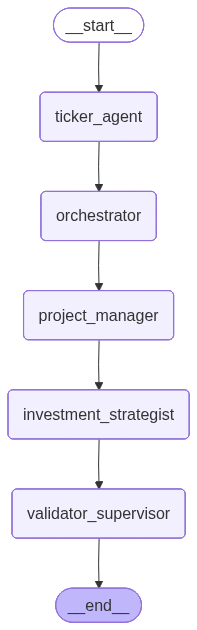

In [ ]:
graph

In [ ]:
async def analyze_company(company_name: str) -> dict:
    print(f"--- 🚀 Starting Heimdall Analysis for: {company_name} ---")
    try:
        # Define initial state for the graph invocation
        initial_state = {
            "company_name": company_name,
            "messages": [HumanMessage(content=f"Generate a full financial intelligence report for {company_name}.")]
        }
        
        # Stream or invoke the graph execution
        final_result = {}
        async for step in graph.astream(initial_state, {"recursion_limit": 100}):
            # Print intermediate steps to monitor progress
            print(f"\n--- Current Node: {list(step.keys())[0]} ---")
            print(step[list(step.keys())[0]])
            final_result = step

        return final_result["final_report"] # Return the final synthesized report

    except Exception as e:
        return {"status": "error", "message": f"An error occurred during analysis: {str(e)}"}
